<a href="https://colab.research.google.com/github/tabba98/neural-network/blob/main/VoxNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the Libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
!pip install torchmetrics
from torchmetrics.classification import Accuracy
from torchmetrics import ConfusionMatrix

!pip install open3d;
import open3d as o3d

#for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

import scipy
from scipy.ndimage import rotate

import time
from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 10.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.5/422.5 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 KB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.9 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
  Attempting uninstall: nbformat
    Found existing installation: nbformat 5.7.3
    Uninstalling nbformat-5.7.3:
      Successfully uninstalled nbformat-5.7.3


# Download and unzip the dataset ModelNet10

In [2]:
!wget http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip

--2023-02-03 13:00:48--  http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Resolving 3dvision.princeton.edu (3dvision.princeton.edu)... 128.112.136.74
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.74|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip [following]
--2023-02-03 13:00:49--  https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473402300 (451M) [application/zip]
Saving to: ‘ModelNet10.zip’

ModelNet10.zip      100%[===================>] 451.47M  38.6MB/s    in 13s     

2023-02-03 13:01:02 (33.7 MB/s) - ‘ModelNet10.zip’ saved [473402300/473402300]



In [3]:
!unzip -q ModelNet10.zip;

# Voxelization of the off. files in dataset

In [4]:
import os

ROOT = '/content/ModelNet10/'
CLASSES = ['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']

X = {'train': [], 'test': []}
Y = {'train': [], 'test': []}

for label, cl in enumerate(CLASSES):
    for split in ['train', 'test']:
        examples_dir = os.path.join(ROOT, cl, split)
        for example in tqdm(os.listdir(examples_dir)):
          voxel_index = []
          if 'off' in example:
            mesh = o3d.io.read_triangle_mesh(examples_dir+'/'+example)
            mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
            voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.05)
            
            X[split].append(voxel_grid)
            Y[split].append(label)


100%|██████████| 101/101 [02:30<00:00,  1.49s/it]


# Dataset setup and Trainer

In [5]:
class VoxelDataset(Dataset):
    def __init__(self, train = True):
      if train:
          self.data = X['train']
          self.label = Y['train']
      else:
          self.data = X['test']
          self.label = Y['test']
        
                
    def __len__(self):
        return len(self.label)

    def __preproc__(self, voxels):
        
        voxel_grid = voxels.get_voxels()
        vox_g = np.zeros((32, 32, 32), dtype=np.int32)
        for i in range (len(voxel_grid)):
          voxel_index = voxel_grid[i].grid_index
          vox_g[voxel_index[0],voxel_index[1],voxel_index[2]] = 1

        #flip x
        if np.random.randint(2):
            vox_g = np.flip(vox_g, axis=0)
        
        #flip y
        if np.random.randint(2):
            vox_g = np.flip(vox_g, axis=1)
        
        angle = 360 * np.random.random_sample(1)[0]
        vox_g = rotate(vox_g, axes=(0, 1), angle=angle, cval=0.0, reshape=False)  
        
        return vox_g.copy()

    def __getitem__(self, idx):
        label = self.label[idx]
        voxels = self.data[idx]
        voxels = self.__preproc__(voxels)
        voxels = np.expand_dims(voxels, axis=0)
        voxels = torch.tensor(voxels).float()
        return voxels, label

In [1]:
from torch.optim import SGD, Adam
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm

class VoxNet_Trainer():
  def __init__(self, hyperparameters):
      #Hypreparameters
      self.learning_rate = hyperparameters["learning_rate"]
      self.batch_size_train = hyperparameters["train_batch_size"]
      self.batch_size_test = hyperparameters["valid_batch_size"]
      self.data_size = hyperparameters["data_size"]
      self.sgd_momentum = hyperparameters["sgd_momentum"]
      self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      self.epochs = hyperparameters["epochs"]
      self.name_model = hyperparameters["model"]
      
      #Dataset
      self.initDataset()
      self.class_names = ["bathtub", "bed", "chair", "desk", "dresser", "monitor", "night_stand", "sofa", "table", "toilet"]
      self.num_classes = len(self.class_names)

      #Model
      self.lr_scheduler_step = hyperparameters["lr_scheduler_step"]
      self.lr_scheduler_gamma = hyperparameters["lr_scheduler_gamma"]
      self.initModel()
  
  def initDataset(self):
      self.train_ds = VoxelDataset(train=True)
      self.test_ds = VoxelDataset(train=False)
      self.train_dataloader = DataLoader(dataset=self.train_ds, batch_size=self.batch_size_train, shuffle=True, drop_last=True)
      self.test_dataloader = DataLoader(dataset=self.test_ds, batch_size=self.batch_size_test)

  def initModel(self):
      if self.name_model == "VoxNet":
          self.model = VoxNet()
          os.mkdir('/content/'+str(self.name_model))
          print("model VoxNet was chosen")
      elif self.name_model == "BatchNormVoxNet":
          self.model = BatchNormVoxNet()
          os.mkdir('/content/'+str(self.name_model))
          print("model BatchNormVoxNet was chosen")
      else:
        self.model = DMPVoxNet()
        os.mkdir('/content/'+str(self.name_model))
        print('model DMPVoxNet was choosen')
      self.device = "cuda" if torch.cuda.is_available() else "cpu"
      self.model.to(self.device)
      #self.opt = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
      self.opt = SGD(self.model.parameters(), lr=self.learning_rate, momentum=self.sgd_momentum)
      #self.loss_fn = nn.CrossEntropyLoss()
      self.loss_fn = nn.NLLLoss()
      self.lr_scheduler = torch.optim.lr_scheduler.StepLR(self.opt, step_size=self.lr_scheduler_step, gamma=self.lr_scheduler_gamma)

  def train(self):
      self.pred_conf, self.y_conf = [], []                                                           
      train_loss_history, valid_loss_history = [], []
      train_acc_history, valid_acc_history = [], []
      train_accuracy = Accuracy(task='multiclass', num_classes=10)
      valid_accuracy = Accuracy(task='multiclass', num_classes=10)

      self.num_batch = len(self.train_ds) / self.batch_size_train
      print(self.num_batch)

      total_time = time.time()

      for epoch in range(self.epochs):
          self.lr_scheduler.step()
          t = time.time()

          train_loss = []                                                         #track training loss
          valid_loss = []
          self.model.train()
          iterator = tqdm(enumerate(self.train_dataloader, 0))
          for i, data in iterator:
              inputs, labels = data[0], data[1]
              inputs = inputs.to(self.device)
              labels = labels.to(self.device)

              self.opt.zero_grad()
              pred = self.model(inputs)  # torch.Size([256, 10])
              loss = self.loss_fn(pred,labels)
              train_loss.append(loss.cpu().data)
              train_accuracy.update(torch.argmax(pred, 1).cpu(), labels.cpu()) 

              loss.backward()
              self.opt.step()
              iterator.set_description(f"Train loss: {loss.cpu().data}")
              
              pred_choice = pred.data.max(1)[1]
              correct = pred_choice.eq(labels.data).cpu().sum()
                      
          with torch.no_grad():
            self.model.eval()
            for j, sample in tqdm(enumerate(self.test_dataloader, 0)):    
                inputs_test, labels_test = sample[0], sample[1]
                inputs_test = inputs_test.to(self.device)
                labels_test = labels_test.to(self.device)
                inputs_test = inputs_test.float()  # 转float, torch.Size([256, 1, 32, 32, 32])
                
                pred_test = self.model(inputs_test)
                loss_test = self.loss_fn(pred_test, labels_test)
                valid_loss.append(loss_test.cpu().data)
                valid_accuracy.update(torch.argmax(pred_test, 1).cpu(), labels_test.cpu())
                pred_choice_test = pred_test.data.max(1)[1]

                correct_test = pred_choice_test.eq(labels_test.data).cpu().sum()
                self.pred_conf.append(torch.argmax(pred_test, 1))
                self.y_conf.append(labels_test)

          # total accuracy over all batches
          total_train_accuracy = train_accuracy.compute()
          total_valid_accuracy = valid_accuracy.compute()
          train_accuracy.reset()
          valid_accuracy.reset()
            
          #track loss and acc for plotting
          train_loss_history.append(torch.mean(torch.tensor(train_loss)))
          valid_loss_history.append(torch.mean(torch.tensor(valid_loss)))
          train_acc_history.append(total_train_accuracy)
          valid_acc_history.append(total_valid_accuracy)
            
          elapsed_time_epoch = time.time() - t   
            
          tmp0 = "epoch:{:3d} /{:3d}".format(epoch+1, self.epochs)
          tmp1 = "time: {:.2f} seconds".format(elapsed_time_epoch)
          tmp2 = "train-loss: {:4.2f}, train-acc: {:.2%}".format(train_loss_history[epoch], train_acc_history[epoch].item())
          tmp3 = "valid-loss: {:4.2f}, valid-acc: {:.2%}\n".format(valid_loss_history[epoch], valid_acc_history[epoch].item())
          print(tmp0, tmp1, tmp2, tmp3, sep="\n")


          ##save best model 
          if epoch>1 and total_valid_accuracy>valid_acc_history[-2]:

              torch.save({'epoch': epoch+1,
                          'model_state_dict': self.model.state_dict(),
                          'optimizer_state_dict': self.opt.state_dict(),
                          'loss': valid_loss_history[-1], 
                          'accuracy': total_valid_accuracy},
	                        '/content/'+str(self.name_model)+'/best_model.pth')

          
          #save history
          self.history = {"train_loss": torch.tensor(train_loss_history), "train_acc": torch.tensor(train_acc_history), 
                          "valid_loss": torch.tensor(valid_loss_history), "valid_acc": torch.tensor(valid_acc_history)}
           
  def getHistory(self):
      return self.history

  def generateConfusionMatrix(self):
      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(acc.numpy()*100))
  
      ##compute confusion matrix
      self.model.eval()
      a = torch.cat(self.pred_conf).cpu()
      b = torch.cat(self.y_conf).cpu()
      confmat = ConfusionMatrix(task='multiclass', num_classes=10, normalize="true")
      self.conf_matrix = confmat(a, b)
      self.conf_matrix = torch.round(self.conf_matrix, decimals=2)

      fig=plt.figure(figsize = (12,7))
      sns.heatmap(self.conf_matrix, annot=True, fmt='g', linewidths=.4, cbar=False)
      tick_marks = np.arange(len(self.class_names))
      plt.xticks(tick_marks, self.class_names, rotation=45)
      plt.yticks(tick_marks, self.class_names, rotation=0)
      plt.title("Confusion Matrix")     

  def getPerClassAccuracy(self):
      per_class_accuracy = 100 * torch.diag(self.conf_matrix) / torch.sum(self.conf_matrix, 1)
      tmp = {}
      for i, x in enumerate(self.class_names):
        tmp[x] = per_class_accuracy[i].item()
      print(tmp)
    
  def showResults(self):
      eps = range(0, len(self.history["train_loss"].cpu()))
        
      sns.set_theme()
      fig, ax = plt.subplots(1, 2, figsize=(14, 4))
      fig.suptitle('Results')
        
      ax[0].plot(eps, smooth(self.history["train_loss"].cpu()), 'g', label='Training Loss')
      ax[0].plot(eps, smooth(self.history["valid_loss"].cpu()), 'b', label='Valid Loss')
      ax[0].set_title('Loss History')
      ax[0].set(xlabel='Epochs', ylabel='Loss')
      ax[0].legend()
        
      ax[1].plot(eps, smooth(self.history["train_acc"].cpu()), 'g', label='Training Accuracy')
      ax[1].plot(eps, smooth(self.history["valid_acc"].cpu()), 'b', label='Valid Accuracy')
      ax[1].set_title('Loss History')
      ax[1].set(xlabel='Epochs', ylabel='Accuracy')
      ax[1].legend()

  def draw_voxels(self):
      mesh = next(iter(self.train_dataloader))
      mesh = mesh[0][0][0]
        
      ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
      ax.voxels(mesh, edgecolor='k')
      plt.show()
        
  def test_on_missing_data(self, missing_rate=0.5):
      test_accuracy = Accuracy(task='multiclass', num_classes=10)

      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(acc.numpy()*100))
  
      self.model.eval()
      for x, y in self.test_dataloader:
          x, y = x.to(self.device), y.to(self.device)
            
          idc = np.random.choice(32**3, size=(int(32**3*missing_rate)), replace=False)
          idc_x = idc%32
          idc_y = np.floor_divide(idc, 32)%32
          idc_z = np.floor_divide(idc, 32*32)%32
          x[:, :, idc_x, idc_y, idc_z] = 0
            
          pred = self.model(x)
          test_accuracy.update(torch.argmax(pred, 1).cpu(), y.cpu())
            
      return test_accuracy.compute()
    
  def missing_data_test(self):
      acc = []
      delta = 200
      eps = np.linspace(0,0.99,delta)
      for x in eps:
          tmp = self.test_on_missing_data(x)
          acc.append(tmp)
            
            
      sns.set_theme()
      plt.figure(figsize=(8, 4))
      plt.plot(eps, smooth(acc))
      plt.title("Missing Data Test", size=20, y=1.05)
      plt.xlabel("missing point ratio", size=15)
      plt.ylabel("accuracy", size=15)
      plt.show()

# VoxNet

In [13]:
from collections import OrderedDict
class VoxNet(nn.Module):
    def __init__(self):
        super(VoxNet, self).__init__()
        n_classes = 10
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=5, stride=2)),
            ('relu1', torch.nn.ReLU()),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=32, kernel_size=3)),
            ('relu2', torch.nn.ReLU()),
            ('pool2', torch.nn.MaxPool3d(2)),
            ('drop2', torch.nn.Dropout(p=0.3))
        ]))
        
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x = self.mlp(x)
        #return x
        return self.logsoftmax(x)

**VoxNet** training

In [14]:
training_hyperparameters = {
    "learning_rate": 0.1,
    "sgd_momentum": 0,
    "data_size": 32,
    "epochs": 100,
    "lr_scheduler_step": 16,
    "lr_scheduler_gamma": 0.7,
    "train_batch_size": 32,
    "valid_batch_size": 32,
    "model" : 'VoxNet'
}    

trainer1 = VoxNet_Trainer(training_hyperparameters)
trainer1.train()

model VoxNet was chosen
124.71875


Train loss: 0.9042448401451111: : 124it [01:15,  1.64it/s]
29it [00:10,  2.83it/s]


epoch:  1 /100
time: 85.80 seconds
train-loss: 1.65, train-acc: 43.78%
valid-loss: 1.53, valid-acc: 47.03%



Train loss: 1.3197112083435059: : 124it [01:15,  1.64it/s]
29it [00:11,  2.48it/s]


epoch:  2 /100
time: 87.53 seconds
train-loss: 1.21, train-acc: 57.38%
valid-loss: 1.30, valid-acc: 54.19%



Train loss: 1.037512183189392: : 124it [01:15,  1.65it/s]
29it [00:10,  2.86it/s]


epoch:  3 /100
time: 85.49 seconds
train-loss: 1.04, train-acc: 63.36%
valid-loss: 1.07, valid-acc: 61.78%



Train loss: 0.8443910479545593: : 124it [01:15,  1.64it/s]
29it [00:10,  2.83it/s]


epoch:  4 /100
time: 86.09 seconds
train-loss: 0.91, train-acc: 68.50%
valid-loss: 0.95, valid-acc: 66.85%



Train loss: 0.8674624562263489: : 124it [01:17,  1.60it/s]
29it [00:10,  2.82it/s]


epoch:  5 /100
time: 87.62 seconds
train-loss: 0.81, train-acc: 72.15%
valid-loss: 1.22, valid-acc: 56.17%



Train loss: 0.5085875988006592: : 124it [01:15,  1.64it/s]
29it [00:10,  2.83it/s]


epoch:  6 /100
time: 86.10 seconds
train-loss: 0.75, train-acc: 74.75%
valid-loss: 0.82, valid-acc: 70.26%



Train loss: 0.9895681738853455: : 124it [01:16,  1.63it/s]
29it [00:10,  2.81it/s]


epoch:  7 /100
time: 86.43 seconds
train-loss: 0.69, train-acc: 77.49%
valid-loss: 0.76, valid-acc: 70.81%



Train loss: 0.7226728796958923: : 124it [01:18,  1.58it/s]
29it [00:10,  2.79it/s]


epoch:  8 /100
time: 89.02 seconds
train-loss: 0.66, train-acc: 77.55%
valid-loss: 0.70, valid-acc: 76.98%



Train loss: 0.445112407207489: : 124it [01:15,  1.64it/s]
29it [00:10,  2.84it/s]


epoch:  9 /100
time: 86.04 seconds
train-loss: 0.62, train-acc: 79.33%
valid-loss: 0.69, valid-acc: 74.12%



Train loss: 0.43965765833854675: : 124it [01:14,  1.65it/s]
29it [00:10,  2.85it/s]


epoch: 10 /100
time: 85.13 seconds
train-loss: 0.60, train-acc: 80.19%
valid-loss: 0.63, valid-acc: 78.30%



Train loss: 0.7475917339324951: : 124it [01:17,  1.60it/s]
29it [00:10,  2.86it/s]


epoch: 11 /100
time: 87.50 seconds
train-loss: 0.57, train-acc: 80.82%
valid-loss: 0.66, valid-acc: 77.97%



Train loss: 0.18139025568962097: : 124it [01:15,  1.64it/s]
29it [00:10,  2.86it/s]


epoch: 12 /100
time: 85.74 seconds
train-loss: 0.54, train-acc: 81.83%
valid-loss: 0.62, valid-acc: 78.63%



Train loss: 0.6389997601509094: : 124it [01:15,  1.64it/s]
29it [00:10,  2.82it/s]


epoch: 13 /100
time: 85.77 seconds
train-loss: 0.54, train-acc: 82.08%
valid-loss: 0.58, valid-acc: 79.96%



Train loss: 0.41869017481803894: : 124it [01:17,  1.60it/s]
29it [00:10,  2.84it/s]


epoch: 14 /100
time: 87.90 seconds
train-loss: 0.52, train-acc: 82.46%
valid-loss: 0.60, valid-acc: 78.08%



Train loss: 0.5931349992752075: : 124it [01:15,  1.64it/s]
29it [00:10,  2.83it/s]


epoch: 15 /100
time: 85.97 seconds
train-loss: 0.50, train-acc: 83.90%
valid-loss: 0.59, valid-acc: 80.07%



Train loss: 0.32085832953453064: : 124it [01:16,  1.63it/s]
29it [00:10,  2.76it/s]


epoch: 16 /100
time: 86.75 seconds
train-loss: 0.45, train-acc: 84.65%
valid-loss: 0.56, valid-acc: 81.83%



Train loss: 0.22689113020896912: : 124it [01:17,  1.60it/s]
29it [00:10,  2.83it/s]


epoch: 17 /100
time: 87.91 seconds
train-loss: 0.42, train-acc: 86.06%
valid-loss: 0.55, valid-acc: 81.94%



Train loss: 0.3380603790283203: : 124it [01:17,  1.61it/s]
29it [00:10,  2.81it/s]


epoch: 18 /100
time: 87.52 seconds
train-loss: 0.41, train-acc: 86.42%
valid-loss: 0.52, valid-acc: 82.93%



Train loss: 0.819121241569519: : 124it [01:17,  1.61it/s]
29it [00:10,  2.77it/s]


epoch: 19 /100
time: 87.55 seconds
train-loss: 0.41, train-acc: 86.34%
valid-loss: 0.57, valid-acc: 80.29%



Train loss: 0.3849034607410431: : 124it [01:18,  1.58it/s]
29it [00:10,  2.83it/s]


epoch: 20 /100
time: 88.73 seconds
train-loss: 0.40, train-acc: 86.90%
valid-loss: 0.56, valid-acc: 80.62%



Train loss: 0.4737091362476349: : 124it [01:16,  1.63it/s]
29it [00:10,  2.83it/s]


epoch: 21 /100
time: 86.30 seconds
train-loss: 0.40, train-acc: 85.74%
valid-loss: 0.53, valid-acc: 83.04%



Train loss: 0.31734606623649597: : 124it [01:16,  1.63it/s]
29it [00:10,  2.74it/s]


epoch: 22 /100
time: 86.67 seconds
train-loss: 0.38, train-acc: 87.30%
valid-loss: 0.51, valid-acc: 83.81%



Train loss: 0.44626280665397644: : 124it [01:17,  1.59it/s]
29it [00:10,  2.80it/s]


epoch: 23 /100
time: 88.32 seconds
train-loss: 0.39, train-acc: 87.20%
valid-loss: 0.49, valid-acc: 83.48%



Train loss: 0.23249860107898712: : 124it [01:16,  1.62it/s]
29it [00:10,  2.75it/s]


epoch: 24 /100
time: 87.20 seconds
train-loss: 0.37, train-acc: 87.85%
valid-loss: 0.53, valid-acc: 83.92%



Train loss: 0.8264815211296082: : 124it [01:17,  1.60it/s]
29it [00:10,  2.80it/s]


epoch: 25 /100
time: 87.83 seconds
train-loss: 0.38, train-acc: 87.58%
valid-loss: 0.53, valid-acc: 84.58%



Train loss: 0.27693846821784973: : 124it [01:18,  1.58it/s]
29it [00:10,  2.80it/s]


epoch: 26 /100
time: 88.78 seconds
train-loss: 0.36, train-acc: 87.98%
valid-loss: 0.53, valid-acc: 82.16%



Train loss: 0.6854285001754761: : 124it [01:16,  1.63it/s]
29it [00:10,  2.83it/s]


epoch: 27 /100
time: 86.30 seconds
train-loss: 0.36, train-acc: 87.42%
valid-loss: 0.53, valid-acc: 81.50%



Train loss: 0.42077121138572693: : 124it [01:15,  1.64it/s]
29it [00:10,  2.81it/s]


epoch: 28 /100
time: 86.18 seconds
train-loss: 0.34, train-acc: 88.36%
valid-loss: 0.48, valid-acc: 83.04%



Train loss: 0.3360247015953064: : 124it [01:16,  1.63it/s]
29it [00:11,  2.49it/s]


epoch: 29 /100
time: 87.96 seconds
train-loss: 0.34, train-acc: 88.81%
valid-loss: 0.51, valid-acc: 83.26%



Train loss: 0.5679149627685547: : 124it [01:16,  1.63it/s]
29it [00:10,  2.83it/s]


epoch: 30 /100
time: 86.38 seconds
train-loss: 0.36, train-acc: 88.03%
valid-loss: 0.48, valid-acc: 83.70%



Train loss: 0.2831915318965912: : 124it [01:15,  1.65it/s]
29it [00:10,  2.86it/s]


epoch: 31 /100
time: 85.20 seconds
train-loss: 0.34, train-acc: 88.81%
valid-loss: 0.51, valid-acc: 82.49%



Train loss: 0.2920877933502197: : 124it [01:15,  1.64it/s]
29it [00:10,  2.83it/s]


epoch: 32 /100
time: 85.74 seconds
train-loss: 0.32, train-acc: 88.79%
valid-loss: 0.51, valid-acc: 83.48%



Train loss: 0.15132713317871094: : 124it [01:16,  1.62it/s]
29it [00:10,  2.82it/s]


epoch: 33 /100
time: 87.03 seconds
train-loss: 0.31, train-acc: 89.47%
valid-loss: 0.50, valid-acc: 83.48%



Train loss: 0.3121141195297241: : 124it [01:14,  1.66it/s]
29it [00:10,  2.83it/s]


epoch: 34 /100
time: 84.96 seconds
train-loss: 0.28, train-acc: 89.99%
valid-loss: 0.49, valid-acc: 83.15%



Train loss: 0.3726363778114319: : 124it [01:15,  1.64it/s]
29it [00:10,  2.82it/s]


epoch: 35 /100
time: 85.96 seconds
train-loss: 0.30, train-acc: 89.74%
valid-loss: 0.47, valid-acc: 84.36%



Train loss: 0.7420909404754639: : 124it [01:17,  1.60it/s]
29it [00:10,  2.85it/s]


epoch: 36 /100
time: 87.62 seconds
train-loss: 0.30, train-acc: 89.67%
valid-loss: 0.49, valid-acc: 83.70%



Train loss: 0.6826727986335754: : 124it [01:15,  1.64it/s]
29it [00:10,  2.79it/s]


epoch: 37 /100
time: 86.26 seconds
train-loss: 0.30, train-acc: 89.82%
valid-loss: 0.48, valid-acc: 84.25%



Train loss: 0.19913829863071442: : 124it [01:15,  1.63it/s]
29it [00:10,  2.80it/s]


epoch: 38 /100
time: 86.23 seconds
train-loss: 0.30, train-acc: 89.64%
valid-loss: 0.47, valid-acc: 85.24%



Train loss: 0.5035239458084106: : 124it [01:17,  1.59it/s]
29it [00:10,  2.83it/s]


epoch: 39 /100
time: 88.21 seconds
train-loss: 0.29, train-acc: 90.02%
valid-loss: 0.49, valid-acc: 83.81%



Train loss: 0.3494582772254944: : 124it [01:15,  1.64it/s]
29it [00:10,  2.82it/s]


epoch: 40 /100
time: 85.86 seconds
train-loss: 0.28, train-acc: 91.03%
valid-loss: 0.52, valid-acc: 84.47%



Train loss: 0.5265493392944336: : 124it [01:15,  1.64it/s]
29it [00:10,  2.81it/s]


epoch: 41 /100
time: 85.82 seconds
train-loss: 0.28, train-acc: 90.47%
valid-loss: 0.48, valid-acc: 83.81%



Train loss: 0.31106823682785034: : 124it [01:16,  1.61it/s]
29it [00:10,  2.87it/s]


epoch: 42 /100
time: 86.96 seconds
train-loss: 0.27, train-acc: 90.73%
valid-loss: 0.49, valid-acc: 84.36%



Train loss: 0.26414433121681213: : 124it [01:15,  1.65it/s]
29it [00:10,  2.88it/s]


epoch: 43 /100
time: 85.16 seconds
train-loss: 0.28, train-acc: 90.65%
valid-loss: 0.50, valid-acc: 84.91%



Train loss: 0.2928119897842407: : 124it [01:14,  1.65it/s]
29it [00:10,  2.86it/s]


epoch: 44 /100
time: 85.15 seconds
train-loss: 0.27, train-acc: 90.52%
valid-loss: 0.49, valid-acc: 84.69%



Train loss: 0.5251541137695312: : 124it [01:15,  1.64it/s]
29it [00:10,  2.80it/s]


epoch: 45 /100
time: 86.16 seconds
train-loss: 0.26, train-acc: 90.95%
valid-loss: 0.49, valid-acc: 83.48%



Train loss: 0.27904844284057617: : 124it [01:17,  1.59it/s]
29it [00:10,  2.83it/s]


epoch: 46 /100
time: 88.23 seconds
train-loss: 0.27, train-acc: 90.40%
valid-loss: 0.48, valid-acc: 83.92%



Train loss: 0.3279547691345215: : 124it [01:15,  1.64it/s]
29it [00:10,  2.84it/s]


epoch: 47 /100
time: 85.83 seconds
train-loss: 0.27, train-acc: 90.93%
valid-loss: 0.50, valid-acc: 84.25%



Train loss: 0.17765669524669647: : 124it [01:15,  1.64it/s]
29it [00:10,  2.80it/s]


epoch: 48 /100
time: 86.06 seconds
train-loss: 0.25, train-acc: 91.20%
valid-loss: 0.46, valid-acc: 85.02%



Train loss: 0.27740561962127686: : 124it [01:17,  1.61it/s]
29it [00:10,  2.82it/s]


epoch: 49 /100
time: 87.41 seconds
train-loss: 0.24, train-acc: 92.01%
valid-loss: 0.47, valid-acc: 84.36%



Train loss: 0.20269712805747986: : 124it [01:15,  1.64it/s]
29it [00:10,  2.85it/s]


epoch: 50 /100
time: 85.61 seconds
train-loss: 0.24, train-acc: 91.81%
valid-loss: 0.48, valid-acc: 84.80%



Train loss: 0.3299585282802582: : 124it [01:15,  1.64it/s]
29it [00:10,  2.84it/s]


epoch: 51 /100
time: 85.73 seconds
train-loss: 0.24, train-acc: 91.46%
valid-loss: 0.51, valid-acc: 84.58%



Train loss: 0.0667274072766304: : 124it [01:16,  1.62it/s]
29it [00:10,  2.84it/s]


epoch: 52 /100
time: 86.80 seconds
train-loss: 0.24, train-acc: 91.10%
valid-loss: 0.47, valid-acc: 83.70%



Train loss: 0.3260709345340729: : 124it [01:15,  1.65it/s]
29it [00:10,  2.85it/s]


epoch: 53 /100
time: 85.40 seconds
train-loss: 0.23, train-acc: 91.91%
valid-loss: 0.50, valid-acc: 83.59%



Train loss: 0.11552363634109497: : 124it [01:15,  1.64it/s]
29it [00:10,  2.83it/s]


epoch: 54 /100
time: 85.71 seconds
train-loss: 0.24, train-acc: 91.68%
valid-loss: 0.44, valid-acc: 84.58%



Train loss: 0.21403604745864868: : 124it [01:16,  1.62it/s]
29it [00:11,  2.44it/s]


epoch: 55 /100
time: 88.64 seconds
train-loss: 0.22, train-acc: 92.59%
valid-loss: 0.47, valid-acc: 84.58%



Train loss: 0.17869603633880615: : 124it [01:16,  1.63it/s]
29it [00:10,  2.77it/s]


epoch: 56 /100
time: 86.69 seconds
train-loss: 0.22, train-acc: 92.69%
valid-loss: 0.47, valid-acc: 85.68%



Train loss: 0.08952492475509644: : 124it [01:15,  1.64it/s]
29it [00:10,  2.81it/s]


epoch: 57 /100
time: 85.89 seconds
train-loss: 0.22, train-acc: 92.16%
valid-loss: 0.50, valid-acc: 84.14%



Train loss: 0.19982704520225525: : 124it [01:15,  1.63it/s]
29it [00:10,  2.76it/s]


epoch: 58 /100
time: 86.52 seconds
train-loss: 0.23, train-acc: 91.99%
valid-loss: 0.47, valid-acc: 84.36%



Train loss: 0.2407228648662567: : 124it [01:18,  1.59it/s]
29it [00:10,  2.81it/s]


epoch: 59 /100
time: 88.36 seconds
train-loss: 0.22, train-acc: 92.26%
valid-loss: 0.51, valid-acc: 83.70%



Train loss: 0.15848274528980255: : 124it [01:16,  1.62it/s]
29it [00:10,  2.83it/s]


epoch: 60 /100
time: 86.72 seconds
train-loss: 0.22, train-acc: 92.34%
valid-loss: 0.47, valid-acc: 85.90%



Train loss: 0.25267064571380615: : 124it [01:15,  1.64it/s]
29it [00:10,  2.84it/s]


epoch: 61 /100
time: 86.00 seconds
train-loss: 0.22, train-acc: 92.64%
valid-loss: 0.47, valid-acc: 83.59%



Train loss: 0.1868717521429062: : 124it [01:17,  1.59it/s]
29it [00:10,  2.78it/s]


epoch: 62 /100
time: 88.23 seconds
train-loss: 0.22, train-acc: 92.31%
valid-loss: 0.44, valid-acc: 85.90%



Train loss: 0.03598259016871452: : 124it [01:15,  1.64it/s]
29it [00:10,  2.87it/s]


epoch: 63 /100
time: 85.72 seconds
train-loss: 0.21, train-acc: 92.44%
valid-loss: 0.47, valid-acc: 85.13%



Train loss: 0.21711011230945587: : 124it [01:15,  1.64it/s]
29it [00:10,  2.84it/s]


epoch: 64 /100
time: 85.79 seconds
train-loss: 0.20, train-acc: 92.69%
valid-loss: 0.50, valid-acc: 85.35%



Train loss: 0.1888778954744339: : 124it [01:15,  1.65it/s]
29it [00:11,  2.53it/s]


epoch: 65 /100
time: 86.82 seconds
train-loss: 0.21, train-acc: 92.46%
valid-loss: 0.46, valid-acc: 85.46%



Train loss: 0.15690742433071136: : 124it [01:16,  1.62it/s]
29it [00:10,  2.80it/s]


epoch: 66 /100
time: 86.90 seconds
train-loss: 0.21, train-acc: 93.22%
valid-loss: 0.46, valid-acc: 86.45%



Train loss: 0.07499885559082031: : 124it [01:16,  1.63it/s]
29it [00:10,  2.79it/s]


epoch: 67 /100
time: 86.47 seconds
train-loss: 0.20, train-acc: 93.35%
valid-loss: 0.47, valid-acc: 86.12%



Train loss: 0.31904828548431396: : 124it [01:15,  1.64it/s]
29it [00:10,  2.81it/s]


epoch: 68 /100
time: 86.07 seconds
train-loss: 0.20, train-acc: 93.07%
valid-loss: 0.48, valid-acc: 85.24%



Train loss: 0.16240015625953674: : 124it [01:18,  1.58it/s]
29it [00:10,  2.80it/s]


epoch: 69 /100
time: 88.64 seconds
train-loss: 0.19, train-acc: 93.42%
valid-loss: 0.48, valid-acc: 84.91%



Train loss: 0.15723833441734314: : 124it [01:16,  1.63it/s]
29it [00:10,  2.83it/s]


epoch: 70 /100
time: 86.50 seconds
train-loss: 0.21, train-acc: 92.57%
valid-loss: 0.47, valid-acc: 85.90%



Train loss: 0.22907227277755737: : 124it [01:17,  1.59it/s]
29it [00:10,  2.79it/s]


epoch: 71 /100
time: 88.38 seconds
train-loss: 0.19, train-acc: 93.25%
valid-loss: 0.47, valid-acc: 85.79%



Train loss: 0.2677116394042969: : 124it [01:17,  1.60it/s]
29it [00:10,  2.83it/s]


epoch: 72 /100
time: 87.78 seconds
train-loss: 0.21, train-acc: 93.27%
valid-loss: 0.45, valid-acc: 85.35%



Train loss: 0.044499464333057404: : 124it [01:16,  1.62it/s]
29it [00:10,  2.80it/s]


epoch: 73 /100
time: 86.78 seconds
train-loss: 0.20, train-acc: 93.20%
valid-loss: 0.49, valid-acc: 84.58%



Train loss: 0.1417580246925354: : 124it [01:15,  1.63it/s]
29it [00:10,  2.81it/s]


epoch: 74 /100
time: 86.34 seconds
train-loss: 0.18, train-acc: 93.50%
valid-loss: 0.46, valid-acc: 86.34%



Train loss: 0.15351220965385437: : 124it [01:17,  1.60it/s]
29it [00:10,  2.85it/s]


epoch: 75 /100
time: 87.77 seconds
train-loss: 0.19, train-acc: 92.89%
valid-loss: 0.49, valid-acc: 86.34%



Train loss: 0.1900738924741745: : 124it [01:16,  1.63it/s]
29it [00:10,  2.77it/s]


epoch: 76 /100
time: 86.70 seconds
train-loss: 0.18, train-acc: 93.37%
valid-loss: 0.48, valid-acc: 84.91%



Train loss: 0.39701706171035767: : 124it [01:15,  1.63it/s]
29it [00:10,  2.78it/s]


epoch: 77 /100
time: 86.34 seconds
train-loss: 0.20, train-acc: 92.82%
valid-loss: 0.48, valid-acc: 85.24%



Train loss: 0.40564459562301636: : 124it [01:17,  1.60it/s]
29it [00:10,  2.80it/s]


epoch: 78 /100
time: 88.05 seconds
train-loss: 0.19, train-acc: 93.35%
valid-loss: 0.48, valid-acc: 85.57%



Train loss: 0.15173622965812683: : 124it [01:18,  1.59it/s]
29it [00:10,  2.75it/s]


epoch: 79 /100
time: 88.65 seconds
train-loss: 0.21, train-acc: 92.79%
valid-loss: 0.46, valid-acc: 85.02%



Train loss: 0.2954050302505493: : 124it [01:20,  1.55it/s]
29it [00:10,  2.64it/s]


epoch: 80 /100
time: 91.03 seconds
train-loss: 0.19, train-acc: 93.32%
valid-loss: 0.48, valid-acc: 86.34%



Train loss: 0.09408175945281982: : 124it [01:19,  1.57it/s]
29it [00:10,  2.74it/s]


epoch: 81 /100
time: 89.70 seconds
train-loss: 0.19, train-acc: 93.52%
valid-loss: 0.45, valid-acc: 86.89%



Train loss: 0.06918147951364517: : 124it [01:17,  1.59it/s]
29it [00:10,  2.77it/s]


epoch: 82 /100
time: 88.47 seconds
train-loss: 0.18, train-acc: 93.50%
valid-loss: 0.49, valid-acc: 85.90%



Train loss: 0.2788447141647339: : 124it [01:16,  1.62it/s]
29it [00:10,  2.83it/s]


epoch: 83 /100
time: 87.04 seconds
train-loss: 0.18, train-acc: 93.62%
valid-loss: 0.49, valid-acc: 86.78%



Train loss: 0.20124222338199615: : 124it [01:18,  1.58it/s]
29it [00:10,  2.84it/s]


epoch: 84 /100
time: 88.52 seconds
train-loss: 0.16, train-acc: 94.38%
valid-loss: 0.48, valid-acc: 85.35%



Train loss: 0.15302230417728424: : 124it [01:15,  1.63it/s]
29it [00:10,  2.82it/s]


epoch: 85 /100
time: 86.15 seconds
train-loss: 0.19, train-acc: 93.45%
valid-loss: 0.47, valid-acc: 85.79%



Train loss: 0.2398649901151657: : 124it [01:15,  1.63it/s]
29it [00:10,  2.84it/s]


epoch: 86 /100
time: 86.16 seconds
train-loss: 0.17, train-acc: 93.67%
valid-loss: 0.48, valid-acc: 87.00%



Train loss: 0.18060420453548431: : 124it [01:17,  1.59it/s]
29it [00:10,  2.81it/s]


epoch: 87 /100
time: 88.28 seconds
train-loss: 0.17, train-acc: 93.67%
valid-loss: 0.47, valid-acc: 85.68%



Train loss: 0.23091770708560944: : 124it [01:15,  1.63it/s]
29it [00:10,  2.79it/s]


epoch: 88 /100
time: 86.43 seconds
train-loss: 0.18, train-acc: 93.47%
valid-loss: 0.47, valid-acc: 86.56%



Train loss: 0.12967389822006226: : 124it [01:15,  1.63it/s]
29it [00:10,  2.81it/s]


epoch: 89 /100
time: 86.22 seconds
train-loss: 0.16, train-acc: 94.53%
valid-loss: 0.46, valid-acc: 85.79%



Train loss: 0.48030513525009155: : 124it [01:16,  1.62it/s]
29it [00:11,  2.44it/s]


epoch: 90 /100
time: 88.33 seconds
train-loss: 0.18, train-acc: 94.08%
valid-loss: 0.49, valid-acc: 86.01%



Train loss: 0.203121617436409: : 124it [01:16,  1.62it/s]
29it [00:10,  2.79it/s]


epoch: 91 /100
time: 86.78 seconds
train-loss: 0.17, train-acc: 94.08%
valid-loss: 0.50, valid-acc: 86.34%



Train loss: 0.0808977261185646: : 124it [01:16,  1.63it/s]
29it [00:10,  2.81it/s]


epoch: 92 /100
time: 86.44 seconds
train-loss: 0.17, train-acc: 93.67%
valid-loss: 0.48, valid-acc: 86.12%



Train loss: 0.09391230344772339: : 124it [01:17,  1.60it/s]
29it [00:11,  2.43it/s]


epoch: 93 /100
time: 89.32 seconds
train-loss: 0.16, train-acc: 94.33%
valid-loss: 0.49, valid-acc: 86.01%



Train loss: 0.049202386289834976: : 124it [01:17,  1.61it/s]
29it [00:10,  2.80it/s]


epoch: 94 /100
time: 87.46 seconds
train-loss: 0.16, train-acc: 94.63%
valid-loss: 0.46, valid-acc: 86.23%



Train loss: 0.2425174117088318: : 124it [01:16,  1.63it/s]
29it [00:10,  2.78it/s]


epoch: 95 /100
time: 86.61 seconds
train-loss: 0.18, train-acc: 93.55%
valid-loss: 0.47, valid-acc: 85.79%



Train loss: 0.12561041116714478: : 124it [01:17,  1.60it/s]
29it [00:12,  2.39it/s]


epoch: 96 /100
time: 89.61 seconds
train-loss: 0.17, train-acc: 94.43%
valid-loss: 0.47, valid-acc: 86.12%



Train loss: 0.19068431854248047: : 124it [01:16,  1.61it/s]
29it [00:10,  2.79it/s]


epoch: 97 /100
time: 87.42 seconds
train-loss: 0.17, train-acc: 94.08%
valid-loss: 0.48, valid-acc: 85.02%



Train loss: 0.05029785633087158: : 124it [01:17,  1.61it/s]
29it [00:10,  2.75it/s]


epoch: 98 /100
time: 87.70 seconds
train-loss: 0.16, train-acc: 93.98%
valid-loss: 0.44, valid-acc: 85.68%



Train loss: 0.10336404293775558: : 124it [01:16,  1.61it/s]
29it [00:10,  2.81it/s]


epoch: 99 /100
time: 87.37 seconds
train-loss: 0.15, train-acc: 94.38%
valid-loss: 0.48, valid-acc: 86.45%



Train loss: 0.19969594478607178: : 124it [01:18,  1.59it/s]
29it [00:10,  2.78it/s]

epoch:100 /100
time: 88.54 seconds
train-loss: 0.16, train-acc: 94.35%
valid-loss: 0.49, valid-acc: 86.23%



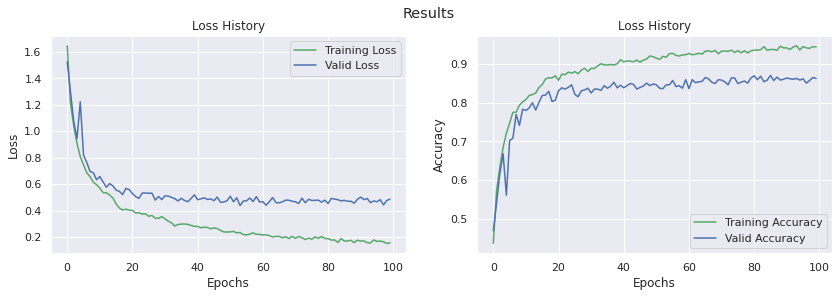

In [15]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history1 = trainer1.getHistory()
trainer1.showResults()

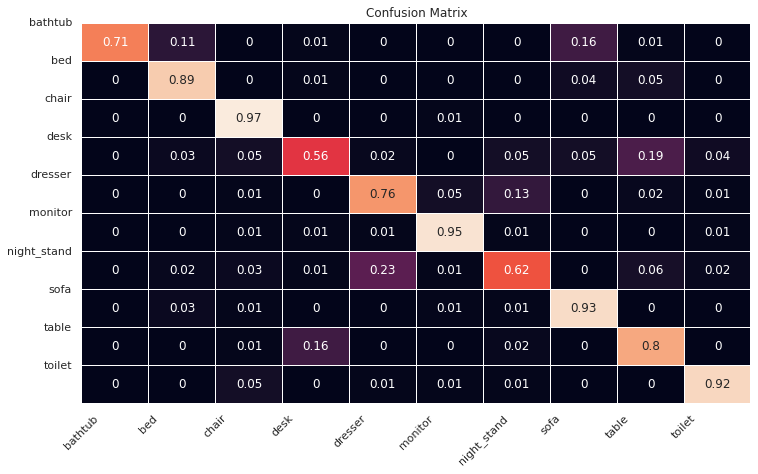

In [16]:
trainer1.generateConfusionMatrix()

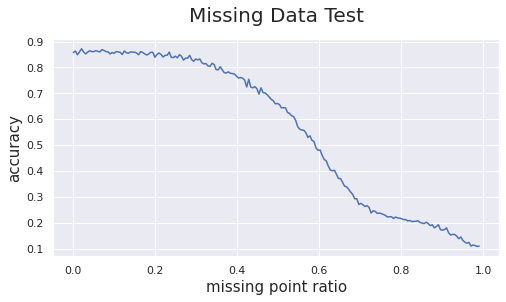

In [ ]:
trainer1.missing_data_test()

# BatcNormVoxNet

In [17]:
from collections import OrderedDict
class BatchNormVoxNet(nn.Module):
    def __init__(self):
        super(BatchNormVoxNet, self).__init__()
        n_classes = 10
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=5, stride=2)),
            ('batch1', torch.nn.BatchNorm3d(32)),
            ('relu1', torch.nn.ReLU()),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=32, kernel_size=3)),
            ('batch2', torch.nn.BatchNorm3d(32)),
            ('relu2', torch.nn.ReLU()),
            ('pool2', torch.nn.MaxPool3d(2)),
            ('drop2', torch.nn.Dropout(p=0.3))
        ]))
        
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x = self.mlp(x)
        #return x
        return self.logsoftmax(x)

**BatchNormVoxNet** Training 

In [18]:
training_hyperparameters = {
    "learning_rate": 0.1,
    "sgd_momentum": 0,
    "data_size": 32,
    "epochs": 100,
    "lr_scheduler_step": 16,
    "lr_scheduler_gamma": 0.7,
    "train_batch_size": 32,
    "valid_batch_size": 32,
    "model" : 'BatchNormVoxNet'
}    

trainer2 = VoxNet_Trainer(training_hyperparameters)
trainer2.train()

model BatchNormVoxNet was chosen
124.71875


Train loss: 2.002948760986328: : 124it [01:19,  1.55it/s]
29it [00:10,  2.77it/s]


epoch:  1 /100
time: 90.31 seconds
train-loss: 1.84, train-acc: 39.62%
valid-loss: 1.57, valid-acc: 42.18%



Train loss: 1.363417387008667: : 124it [01:25,  1.45it/s]
29it [00:10,  2.78it/s]


epoch:  2 /100
time: 96.27 seconds
train-loss: 1.36, train-acc: 52.37%
valid-loss: 1.16, valid-acc: 57.05%



Train loss: 1.097217321395874: : 124it [01:19,  1.55it/s]
29it [00:10,  2.71it/s]


epoch:  3 /100
time: 90.69 seconds
train-loss: 1.10, train-acc: 62.70%
valid-loss: 1.05, valid-acc: 60.90%



Train loss: 1.169645071029663: : 124it [01:21,  1.52it/s]
29it [00:10,  2.77it/s]


epoch:  4 /100
time: 92.13 seconds
train-loss: 0.99, train-acc: 67.01%
valid-loss: 0.90, valid-acc: 68.39%



Train loss: 0.551538348197937: : 124it [01:21,  1.52it/s]
29it [00:10,  2.78it/s]


epoch:  5 /100
time: 92.03 seconds
train-loss: 0.89, train-acc: 69.73%
valid-loss: 0.89, valid-acc: 67.73%



Train loss: 0.79179847240448: : 124it [01:20,  1.55it/s]
29it [00:10,  2.76it/s]


epoch:  6 /100
time: 90.75 seconds
train-loss: 0.83, train-acc: 71.70%
valid-loss: 0.84, valid-acc: 68.17%



Train loss: 0.7116702795028687: : 124it [01:20,  1.54it/s]
29it [00:10,  2.71it/s]


epoch:  7 /100
time: 91.44 seconds
train-loss: 0.77, train-acc: 73.89%
valid-loss: 0.83, valid-acc: 68.06%



Train loss: 1.042616605758667: : 124it [01:22,  1.51it/s]
29it [00:10,  2.72it/s]


epoch:  8 /100
time: 93.01 seconds
train-loss: 0.73, train-acc: 75.50%
valid-loss: 0.75, valid-acc: 72.69%



Train loss: 1.168976068496704: : 124it [01:20,  1.54it/s]
29it [00:10,  2.76it/s]


epoch:  9 /100
time: 90.92 seconds
train-loss: 0.70, train-acc: 76.86%
valid-loss: 0.70, valid-acc: 75.22%



Train loss: 0.37689483165740967: : 124it [01:20,  1.54it/s]
29it [00:10,  2.78it/s]


epoch: 10 /100
time: 91.07 seconds
train-loss: 0.67, train-acc: 77.67%
valid-loss: 0.76, valid-acc: 72.36%



Train loss: 0.5705105662345886: : 124it [01:22,  1.51it/s]
29it [00:10,  2.79it/s]


epoch: 11 /100
time: 92.45 seconds
train-loss: 0.63, train-acc: 78.15%
valid-loss: 0.69, valid-acc: 74.45%



Train loss: 0.6119962930679321: : 124it [01:20,  1.55it/s]
29it [00:10,  2.76it/s]


epoch: 12 /100
time: 90.69 seconds
train-loss: 0.64, train-acc: 78.30%
valid-loss: 0.65, valid-acc: 77.09%



Train loss: 0.6220983266830444: : 124it [01:19,  1.55it/s]
29it [00:10,  2.75it/s]


epoch: 13 /100
time: 90.34 seconds
train-loss: 0.60, train-acc: 80.09%
valid-loss: 0.67, valid-acc: 75.66%



Train loss: 0.744928240776062: : 124it [01:21,  1.52it/s]
29it [00:10,  2.74it/s]


epoch: 14 /100
time: 92.18 seconds
train-loss: 0.59, train-acc: 80.80%
valid-loss: 0.65, valid-acc: 75.44%



Train loss: 0.3185940682888031: : 124it [01:19,  1.57it/s]
29it [00:10,  2.78it/s]


epoch: 15 /100
time: 89.56 seconds
train-loss: 0.56, train-acc: 81.33%
valid-loss: 0.61, valid-acc: 78.63%



Train loss: 0.3620068430900574: : 124it [01:19,  1.55it/s]
29it [00:10,  2.76it/s]


epoch: 16 /100
time: 90.55 seconds
train-loss: 0.50, train-acc: 83.67%
valid-loss: 0.59, valid-acc: 79.30%



Train loss: 0.7100423574447632: : 124it [01:21,  1.53it/s]
29it [00:10,  2.78it/s]


epoch: 17 /100
time: 91.61 seconds
train-loss: 0.50, train-acc: 83.62%
valid-loss: 0.57, valid-acc: 78.85%



Train loss: 0.1271248608827591: : 124it [01:19,  1.55it/s]
29it [00:10,  2.80it/s]


epoch: 18 /100
time: 90.38 seconds
train-loss: 0.48, train-acc: 83.87%
valid-loss: 0.59, valid-acc: 80.18%



Train loss: 0.26925376057624817: : 124it [01:20,  1.55it/s]
29it [00:11,  2.43it/s]


epoch: 19 /100
time: 92.03 seconds
train-loss: 0.47, train-acc: 84.53%
valid-loss: 0.56, valid-acc: 80.95%



Train loss: 0.3643304407596588: : 124it [01:20,  1.55it/s]
29it [00:10,  2.73it/s]


epoch: 20 /100
time: 90.73 seconds
train-loss: 0.45, train-acc: 85.06%
valid-loss: 0.55, valid-acc: 81.39%



Train loss: 0.7070004343986511: : 124it [01:19,  1.56it/s]
29it [00:10,  2.71it/s]


epoch: 21 /100
time: 90.44 seconds
train-loss: 0.46, train-acc: 84.93%
valid-loss: 0.60, valid-acc: 79.74%



Train loss: 0.4829677939414978: : 124it [01:21,  1.52it/s]
29it [00:10,  2.79it/s]


epoch: 22 /100
time: 91.90 seconds
train-loss: 0.45, train-acc: 84.65%
valid-loss: 0.54, valid-acc: 81.83%



Train loss: 0.3982602655887604: : 124it [01:19,  1.56it/s]
29it [00:10,  2.77it/s]


epoch: 23 /100
time: 89.96 seconds
train-loss: 0.45, train-acc: 85.58%
valid-loss: 0.54, valid-acc: 81.50%



Train loss: 0.5812430381774902: : 124it [01:19,  1.56it/s]
29it [00:10,  2.80it/s]


epoch: 24 /100
time: 89.75 seconds
train-loss: 0.43, train-acc: 85.86%
valid-loss: 0.55, valid-acc: 80.29%



Train loss: 0.05055713653564453: : 124it [01:21,  1.53it/s]
29it [00:10,  2.78it/s]


epoch: 25 /100
time: 91.49 seconds
train-loss: 0.43, train-acc: 85.41%
valid-loss: 0.53, valid-acc: 82.27%



Train loss: 0.5096548795700073: : 124it [01:18,  1.57it/s]
29it [00:10,  2.78it/s]


epoch: 26 /100
time: 89.24 seconds
train-loss: 0.42, train-acc: 85.94%
valid-loss: 0.55, valid-acc: 82.05%



Train loss: 0.46530279517173767: : 124it [01:19,  1.57it/s]
29it [00:10,  2.80it/s]


epoch: 27 /100
time: 89.48 seconds
train-loss: 0.40, train-acc: 85.76%
valid-loss: 0.52, valid-acc: 81.28%



Train loss: 0.24957378208637238: : 124it [01:20,  1.53it/s]
29it [00:10,  2.76it/s]


epoch: 28 /100
time: 91.42 seconds
train-loss: 0.42, train-acc: 85.89%
valid-loss: 0.52, valid-acc: 81.72%



Train loss: 0.477804034948349: : 124it [01:19,  1.56it/s]
29it [00:10,  2.78it/s]


epoch: 29 /100
time: 90.04 seconds
train-loss: 0.41, train-acc: 86.62%
valid-loss: 0.52, valid-acc: 81.72%



Train loss: 0.2295013666152954: : 124it [01:20,  1.54it/s]
29it [00:10,  2.81it/s]


epoch: 30 /100
time: 90.65 seconds
train-loss: 0.39, train-acc: 86.42%
valid-loss: 0.49, valid-acc: 82.60%



Train loss: 0.7557701468467712: : 124it [01:18,  1.57it/s]
29it [00:10,  2.81it/s]


epoch: 31 /100
time: 89.19 seconds
train-loss: 0.40, train-acc: 86.14%
valid-loss: 0.57, valid-acc: 80.40%



Train loss: 0.3357265591621399: : 124it [01:19,  1.55it/s]
29it [00:10,  2.78it/s]


epoch: 32 /100
time: 90.32 seconds
train-loss: 0.38, train-acc: 87.20%
valid-loss: 0.46, valid-acc: 83.37%



Train loss: 0.2775598168373108: : 124it [01:20,  1.54it/s]
29it [00:10,  2.77it/s]


epoch: 33 /100
time: 91.26 seconds
train-loss: 0.35, train-acc: 87.65%
valid-loss: 0.51, valid-acc: 82.16%



Train loss: 0.6598610281944275: : 124it [01:19,  1.57it/s]
29it [00:10,  2.82it/s]


epoch: 34 /100
time: 89.35 seconds
train-loss: 0.34, train-acc: 88.56%
valid-loss: 0.47, valid-acc: 83.59%



Train loss: 0.1338314712047577: : 124it [01:18,  1.58it/s]
29it [00:10,  2.82it/s]


epoch: 35 /100
time: 88.69 seconds
train-loss: 0.35, train-acc: 88.28%
valid-loss: 0.48, valid-acc: 81.94%



Train loss: 0.2899952828884125: : 124it [01:20,  1.54it/s]
29it [00:10,  2.80it/s]


epoch: 36 /100
time: 90.75 seconds
train-loss: 0.34, train-acc: 88.41%
valid-loss: 0.48, valid-acc: 83.92%



Train loss: 0.47882384061813354: : 124it [01:18,  1.58it/s]
29it [00:10,  2.81it/s]


epoch: 37 /100
time: 89.01 seconds
train-loss: 0.35, train-acc: 87.90%
valid-loss: 0.47, valid-acc: 82.38%



Train loss: 0.3970596492290497: : 124it [01:20,  1.55it/s]
29it [00:10,  2.83it/s]


epoch: 38 /100
time: 90.37 seconds
train-loss: 0.33, train-acc: 88.99%
valid-loss: 0.48, valid-acc: 84.47%



Train loss: 0.24871619045734406: : 124it [01:19,  1.56it/s]
29it [00:10,  2.80it/s]


epoch: 39 /100
time: 89.69 seconds
train-loss: 0.34, train-acc: 88.43%
valid-loss: 0.48, valid-acc: 82.16%



Train loss: 0.19881680607795715: : 124it [01:19,  1.57it/s]
29it [00:10,  2.78it/s]


epoch: 40 /100
time: 89.63 seconds
train-loss: 0.32, train-acc: 88.73%
valid-loss: 0.46, valid-acc: 84.69%



Train loss: 0.1364474892616272: : 124it [01:20,  1.55it/s]
29it [00:10,  2.81it/s]


epoch: 41 /100
time: 90.54 seconds
train-loss: 0.33, train-acc: 88.84%
valid-loss: 0.47, valid-acc: 83.48%



Train loss: 0.3731640875339508: : 124it [01:18,  1.57it/s]
29it [00:10,  2.83it/s]


epoch: 42 /100
time: 89.00 seconds
train-loss: 0.32, train-acc: 88.91%
valid-loss: 0.50, valid-acc: 83.81%



Train loss: 0.1782444715499878: : 124it [01:20,  1.53it/s]
29it [00:10,  2.79it/s]


epoch: 43 /100
time: 91.41 seconds
train-loss: 0.31, train-acc: 89.52%
valid-loss: 0.44, valid-acc: 83.81%



Train loss: 0.2832406461238861: : 124it [01:19,  1.57it/s]
29it [00:10,  2.79it/s]


epoch: 44 /100
time: 89.50 seconds
train-loss: 0.32, train-acc: 89.29%
valid-loss: 0.50, valid-acc: 82.38%



Train loss: 0.23084373772144318: : 124it [01:18,  1.58it/s]
29it [00:10,  2.81it/s]


epoch: 45 /100
time: 88.81 seconds
train-loss: 0.32, train-acc: 89.39%
valid-loss: 0.47, valid-acc: 85.02%



Train loss: 0.138685405254364: : 124it [01:19,  1.57it/s]
29it [00:10,  2.85it/s]


epoch: 46 /100
time: 89.38 seconds
train-loss: 0.33, train-acc: 88.91%
valid-loss: 0.47, valid-acc: 82.93%



Train loss: 0.26595672965049744: : 124it [01:19,  1.56it/s]
29it [00:10,  2.87it/s]


epoch: 47 /100
time: 89.38 seconds
train-loss: 0.31, train-acc: 89.26%
valid-loss: 0.46, valid-acc: 83.70%



Train loss: 0.1700792759656906: : 124it [01:18,  1.57it/s]
29it [00:10,  2.82it/s]


epoch: 48 /100
time: 89.22 seconds
train-loss: 0.29, train-acc: 89.82%
valid-loss: 0.46, valid-acc: 84.91%



Train loss: 0.39428868889808655: : 124it [01:18,  1.58it/s]
29it [00:10,  2.77it/s]


epoch: 49 /100
time: 89.17 seconds
train-loss: 0.29, train-acc: 90.22%
valid-loss: 0.45, valid-acc: 83.92%



Train loss: 0.5153487324714661: : 124it [01:18,  1.57it/s]
29it [00:10,  2.79it/s]


epoch: 50 /100
time: 89.20 seconds
train-loss: 0.29, train-acc: 90.05%
valid-loss: 0.49, valid-acc: 83.81%



Train loss: 0.36294904351234436: : 124it [01:20,  1.55it/s]
29it [00:10,  2.83it/s]


epoch: 51 /100
time: 90.39 seconds
train-loss: 0.28, train-acc: 90.05%
valid-loss: 0.47, valid-acc: 84.47%



Train loss: 0.22803746163845062: : 124it [01:18,  1.57it/s]
29it [00:10,  2.75it/s]


epoch: 52 /100
time: 89.47 seconds
train-loss: 0.28, train-acc: 89.74%
valid-loss: 0.46, valid-acc: 85.24%



Train loss: 0.2727186381816864: : 124it [01:21,  1.53it/s]
29it [00:10,  2.76it/s]


epoch: 53 /100
time: 91.73 seconds
train-loss: 0.29, train-acc: 90.20%
valid-loss: 0.46, valid-acc: 83.15%



Train loss: 0.3299904763698578: : 124it [01:18,  1.57it/s]
29it [00:10,  2.75it/s]


epoch: 54 /100
time: 89.52 seconds
train-loss: 0.27, train-acc: 90.50%
valid-loss: 0.48, valid-acc: 84.58%



Train loss: 0.2151140570640564: : 124it [01:18,  1.57it/s]
29it [00:10,  2.81it/s]


epoch: 55 /100
time: 89.19 seconds
train-loss: 0.28, train-acc: 90.52%
valid-loss: 0.49, valid-acc: 83.48%



Train loss: 0.302164763212204: : 124it [01:19,  1.56it/s]
29it [00:10,  2.82it/s]


epoch: 56 /100
time: 89.87 seconds
train-loss: 0.28, train-acc: 90.15%
valid-loss: 0.47, valid-acc: 84.80%



Train loss: 0.22393792867660522: : 124it [01:18,  1.58it/s]
29it [00:10,  2.81it/s]


epoch: 57 /100
time: 88.81 seconds
train-loss: 0.28, train-acc: 89.99%
valid-loss: 0.46, valid-acc: 84.69%



Train loss: 0.19201400876045227: : 124it [01:19,  1.57it/s]
29it [00:10,  2.81it/s]


epoch: 58 /100
time: 89.54 seconds
train-loss: 0.27, train-acc: 90.70%
valid-loss: 0.45, valid-acc: 84.58%



Train loss: 0.4496433436870575: : 124it [01:18,  1.57it/s]
29it [00:10,  2.82it/s]


epoch: 59 /100
time: 89.19 seconds
train-loss: 0.27, train-acc: 89.97%
valid-loss: 0.43, valid-acc: 85.46%



Train loss: 0.37988677620887756: : 124it [01:18,  1.57it/s]
29it [00:10,  2.80it/s]


epoch: 60 /100
time: 89.28 seconds
train-loss: 0.28, train-acc: 90.93%
valid-loss: 0.47, valid-acc: 83.81%



Train loss: 0.13911615312099457: : 124it [01:19,  1.55it/s]
29it [00:10,  2.83it/s]


epoch: 61 /100
time: 90.08 seconds
train-loss: 0.26, train-acc: 91.00%
valid-loss: 0.48, valid-acc: 83.81%



Train loss: 0.24920719861984253: : 124it [01:18,  1.59it/s]
29it [00:10,  2.83it/s]


epoch: 62 /100
time: 88.46 seconds
train-loss: 0.29, train-acc: 90.47%
valid-loss: 0.45, valid-acc: 84.03%



Train loss: 0.21412573754787445: : 124it [01:19,  1.55it/s]
29it [00:10,  2.83it/s]


epoch: 63 /100
time: 90.08 seconds
train-loss: 0.26, train-acc: 91.08%
valid-loss: 0.46, valid-acc: 84.47%



Train loss: 0.19937345385551453: : 124it [01:18,  1.58it/s]
29it [00:10,  2.84it/s]


epoch: 64 /100
time: 88.98 seconds
train-loss: 0.27, train-acc: 91.05%
valid-loss: 0.46, valid-acc: 83.81%



Train loss: 0.18850576877593994: : 124it [01:18,  1.59it/s]
29it [00:10,  2.79it/s]


epoch: 65 /100
time: 88.63 seconds
train-loss: 0.25, train-acc: 91.36%
valid-loss: 0.47, valid-acc: 85.13%



Train loss: 0.2987578213214874: : 124it [01:19,  1.56it/s]
29it [00:10,  2.78it/s]


epoch: 66 /100
time: 89.82 seconds
train-loss: 0.24, train-acc: 91.53%
valid-loss: 0.45, valid-acc: 85.46%



Train loss: 0.5450367331504822: : 124it [01:18,  1.58it/s]
29it [00:10,  2.80it/s]


epoch: 67 /100
time: 89.00 seconds
train-loss: 0.24, train-acc: 91.63%
valid-loss: 0.45, valid-acc: 84.80%



Train loss: 0.39091557264328003: : 124it [01:19,  1.56it/s]
29it [00:10,  2.87it/s]


epoch: 68 /100
time: 89.77 seconds
train-loss: 0.25, train-acc: 90.90%
valid-loss: 0.42, valid-acc: 86.23%



Train loss: 0.31964775919914246: : 124it [01:18,  1.59it/s]
29it [00:10,  2.81it/s]


epoch: 69 /100
time: 88.37 seconds
train-loss: 0.24, train-acc: 91.78%
valid-loss: 0.45, valid-acc: 85.35%



Train loss: 0.5192252397537231: : 124it [01:18,  1.58it/s]
29it [00:10,  2.82it/s]


epoch: 70 /100
time: 89.05 seconds
train-loss: 0.24, train-acc: 91.53%
valid-loss: 0.45, valid-acc: 85.57%



Train loss: 0.2166414111852646: : 124it [01:19,  1.56it/s]
29it [00:10,  2.81it/s]


epoch: 71 /100
time: 89.76 seconds
train-loss: 0.26, train-acc: 91.00%
valid-loss: 0.46, valid-acc: 83.59%



Train loss: 0.12972484529018402: : 124it [01:18,  1.58it/s]
29it [00:10,  2.80it/s]


epoch: 72 /100
time: 88.83 seconds
train-loss: 0.24, train-acc: 92.14%
valid-loss: 0.46, valid-acc: 84.47%



Train loss: 0.24203693866729736: : 124it [01:20,  1.54it/s]
29it [00:10,  2.79it/s]


epoch: 73 /100
time: 90.91 seconds
train-loss: 0.24, train-acc: 91.73%
valid-loss: 0.47, valid-acc: 85.35%



Train loss: 0.0863124430179596: : 124it [01:19,  1.56it/s]
29it [00:10,  2.81it/s]


epoch: 74 /100
time: 89.66 seconds
train-loss: 0.24, train-acc: 91.23%
valid-loss: 0.46, valid-acc: 84.69%



Train loss: 0.26730188727378845: : 124it [01:19,  1.57it/s]
29it [00:10,  2.79it/s]


epoch: 75 /100
time: 89.43 seconds
train-loss: 0.24, train-acc: 91.43%
valid-loss: 0.45, valid-acc: 85.79%



Train loss: 0.241261288523674: : 124it [01:19,  1.56it/s]
29it [00:10,  2.82it/s]


epoch: 76 /100
time: 89.82 seconds
train-loss: 0.24, train-acc: 91.63%
valid-loss: 0.44, valid-acc: 84.80%



Train loss: 0.4183228313922882: : 124it [01:18,  1.58it/s]
29it [00:10,  2.80it/s]


epoch: 77 /100
time: 88.67 seconds
train-loss: 0.23, train-acc: 92.06%
valid-loss: 0.45, valid-acc: 85.35%



Train loss: 0.33666592836380005: : 124it [01:19,  1.56it/s]
29it [00:10,  2.80it/s]


epoch: 78 /100
time: 90.12 seconds
train-loss: 0.22, train-acc: 92.34%
valid-loss: 0.45, valid-acc: 86.45%



Train loss: 0.3452683687210083: : 124it [01:18,  1.57it/s]
29it [00:10,  2.79it/s]


epoch: 79 /100
time: 89.19 seconds
train-loss: 0.24, train-acc: 92.01%
valid-loss: 0.47, valid-acc: 85.35%



Train loss: 0.3165940046310425: : 124it [01:19,  1.57it/s]
29it [00:11,  2.51it/s]


epoch: 80 /100
time: 90.83 seconds
train-loss: 0.23, train-acc: 91.63%
valid-loss: 0.46, valid-acc: 84.91%



Train loss: 0.23932567238807678: : 124it [01:19,  1.56it/s]
29it [00:10,  2.77it/s]


epoch: 81 /100
time: 90.08 seconds
train-loss: 0.21, train-acc: 92.57%
valid-loss: 0.46, valid-acc: 84.58%



Train loss: 0.19527274370193481: : 124it [01:20,  1.55it/s]
29it [00:10,  2.73it/s]


epoch: 82 /100
time: 90.68 seconds
train-loss: 0.22, train-acc: 92.59%
valid-loss: 0.49, valid-acc: 84.36%



Train loss: 0.31703346967697144: : 124it [01:21,  1.53it/s]
29it [00:10,  2.75it/s]


epoch: 83 /100
time: 91.75 seconds
train-loss: 0.23, train-acc: 92.14%
valid-loss: 0.46, valid-acc: 84.80%



Train loss: 0.057760778814554214: : 124it [01:18,  1.58it/s]
29it [00:10,  2.81it/s]


epoch: 84 /100
time: 89.04 seconds
train-loss: 0.22, train-acc: 92.59%
valid-loss: 0.44, valid-acc: 85.57%



Train loss: 0.2256813645362854: : 124it [01:20,  1.54it/s]
29it [00:10,  2.74it/s]


epoch: 85 /100
time: 90.92 seconds
train-loss: 0.23, train-acc: 91.48%
valid-loss: 0.45, valid-acc: 84.58%



Train loss: 0.254646360874176: : 124it [01:20,  1.55it/s]
29it [00:10,  2.76it/s]


epoch: 86 /100
time: 90.63 seconds
train-loss: 0.22, train-acc: 91.99%
valid-loss: 0.47, valid-acc: 85.68%



Train loss: 0.3599627912044525: : 124it [01:21,  1.53it/s]
29it [00:10,  2.69it/s]


epoch: 87 /100
time: 92.04 seconds
train-loss: 0.21, train-acc: 92.54%
valid-loss: 0.45, valid-acc: 85.79%



Train loss: 0.1754290908575058: : 124it [01:25,  1.46it/s]
29it [00:11,  2.49it/s]


epoch: 88 /100
time: 96.88 seconds
train-loss: 0.21, train-acc: 92.54%
valid-loss: 0.46, valid-acc: 84.58%



Train loss: 0.1771642565727234: : 124it [01:23,  1.48it/s]
29it [00:10,  2.69it/s]


epoch: 89 /100
time: 94.82 seconds
train-loss: 0.21, train-acc: 92.52%
valid-loss: 0.44, valid-acc: 85.57%



Train loss: 0.14321812987327576: : 124it [01:21,  1.52it/s]
29it [00:10,  2.66it/s]


epoch: 90 /100
time: 92.65 seconds
train-loss: 0.20, train-acc: 92.84%
valid-loss: 0.48, valid-acc: 84.25%



Train loss: 0.2198631465435028: : 124it [01:20,  1.54it/s]
29it [00:11,  2.63it/s]


epoch: 91 /100
time: 91.65 seconds
train-loss: 0.20, train-acc: 92.94%
valid-loss: 0.49, valid-acc: 84.69%



Train loss: 0.057133324444293976: : 124it [01:21,  1.53it/s]
29it [00:10,  2.76it/s]


epoch: 92 /100
time: 91.87 seconds
train-loss: 0.20, train-acc: 92.74%
valid-loss: 0.47, valid-acc: 85.57%



Train loss: 0.11056642979383469: : 124it [01:20,  1.54it/s]
29it [00:10,  2.68it/s]


epoch: 93 /100
time: 91.41 seconds
train-loss: 0.21, train-acc: 92.62%
valid-loss: 0.47, valid-acc: 84.69%



Train loss: 0.22791071236133575: : 124it [01:20,  1.54it/s]
29it [00:10,  2.79it/s]


epoch: 94 /100
time: 91.02 seconds
train-loss: 0.22, train-acc: 92.21%
valid-loss: 0.47, valid-acc: 85.35%



Train loss: 0.0983327180147171: : 124it [01:19,  1.57it/s]
29it [00:10,  2.80it/s]


epoch: 95 /100
time: 89.52 seconds
train-loss: 0.21, train-acc: 92.67%
valid-loss: 0.46, valid-acc: 84.69%



Train loss: 0.15638430416584015: : 124it [01:20,  1.54it/s]
29it [00:10,  2.80it/s]


epoch: 96 /100
time: 90.83 seconds
train-loss: 0.21, train-acc: 92.11%
valid-loss: 0.44, valid-acc: 86.89%



Train loss: 0.2243718057870865: : 124it [01:19,  1.57it/s]
29it [00:10,  2.80it/s]


epoch: 97 /100
time: 89.54 seconds
train-loss: 0.21, train-acc: 93.17%
valid-loss: 0.45, valid-acc: 85.90%



Train loss: 0.2580427825450897: : 124it [01:18,  1.57it/s]
29it [00:10,  2.78it/s]


epoch: 98 /100
time: 89.24 seconds
train-loss: 0.21, train-acc: 92.29%
valid-loss: 0.46, valid-acc: 85.35%



Train loss: 0.23096662759780884: : 124it [01:20,  1.54it/s]
29it [00:10,  2.71it/s]


epoch: 99 /100
time: 91.24 seconds
train-loss: 0.20, train-acc: 93.09%
valid-loss: 0.45, valid-acc: 85.35%



Train loss: 0.11129879206418991: : 124it [01:20,  1.55it/s]
29it [00:10,  2.76it/s]

epoch:100 /100
time: 90.72 seconds
train-loss: 0.22, train-acc: 92.09%
valid-loss: 0.47, valid-acc: 84.80%



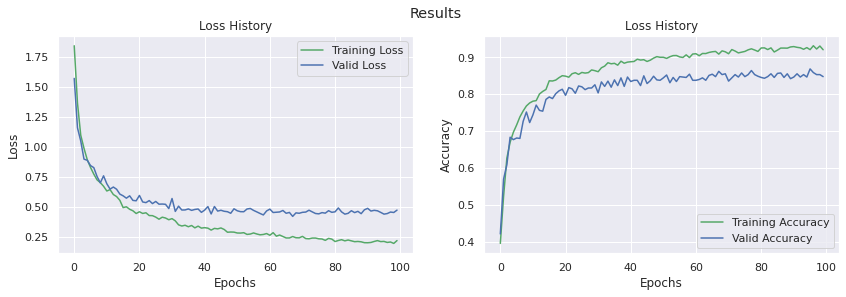

In [19]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history2 = trainer2.getHistory()
trainer2.showResults()

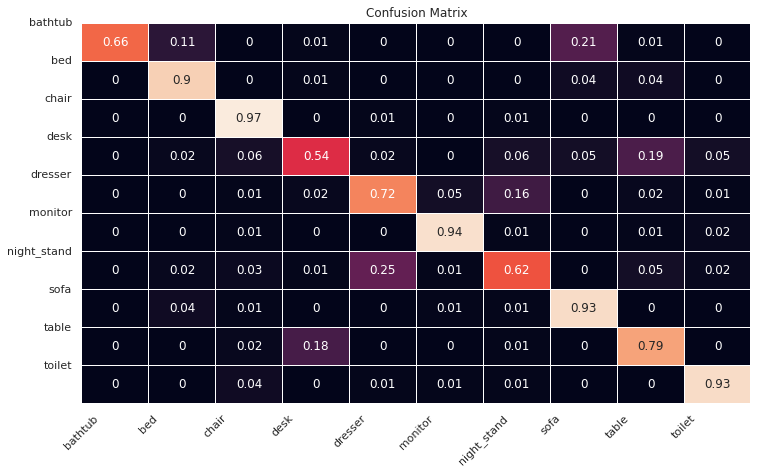

In [20]:
trainer2.generateConfusionMatrix()

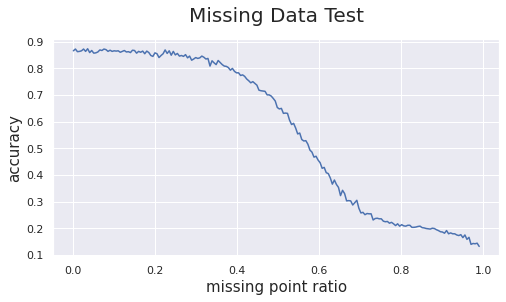

In [ ]:
trainer2.missing_data_test()

# DMPVoxNet (double-max-pooling VoxNet)

In [21]:
from collections import OrderedDict
class DMPVoxNet(nn.Module):
    def __init__(self):
        super(DMPVoxNet, self).__init__()
        n_classes = 10
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=5, stride=2)),
            ('relu1', torch.nn.ReLU()),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=32, kernel_size=3)),
            ('relu2', torch.nn.ReLU()),
            ('pool2', torch.nn.MaxPool3d(2)),
            ('drop2', torch.nn.Dropout(p=0.3)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=128, kernel_size=3)),
            ('relu2', torch.nn.ReLU()),
            ('pool2', torch.nn.MaxPool3d(2)),
            ('drop2', torch.nn.Dropout(p=0.3))
        ]))
        
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x = self.mlp(x)
        #return x
        return self.logsoftmax(x)

**DMPVoxNet** training

In [22]:
training_hyperparameters = {
    "learning_rate": 0.1,
    "sgd_momentum": 0,
    "data_size": 32,
    "epochs": 100,
    "lr_scheduler_step": 16,
    "lr_scheduler_gamma": 0.7,
    "train_batch_size": 32,
    "valid_batch_size": 32,
    "model" : 'LightNet'
}    

trainer3 = VoxNet_Trainer(training_hyperparameters)
trainer3.train()

model DMPVoxNet was choosen
124.71875


Train loss: 1.560144305229187: : 124it [02:37,  1.27s/it]
29it [00:15,  1.93it/s]


epoch:  1 /100
time: 172.70 seconds
train-loss: 1.63, train-acc: 44.13%
valid-loss: 1.54, valid-acc: 38.11%



Train loss: 1.2418259382247925: : 124it [02:22,  1.15s/it]
29it [00:15,  1.91it/s]


epoch:  2 /100
time: 157.32 seconds
train-loss: 1.20, train-acc: 58.44%
valid-loss: 1.13, valid-acc: 58.04%



Train loss: 1.020615816116333: : 124it [02:20,  1.14s/it]
29it [00:16,  1.76it/s]


epoch:  3 /100
time: 157.24 seconds
train-loss: 1.01, train-acc: 64.92%
valid-loss: 1.03, valid-acc: 63.33%



Train loss: 1.0218662023544312: : 124it [02:18,  1.12s/it]
29it [00:14,  1.95it/s]


epoch:  4 /100
time: 153.65 seconds
train-loss: 0.88, train-acc: 69.98%
valid-loss: 0.91, valid-acc: 68.94%



Train loss: 0.6460617780685425: : 124it [02:19,  1.13s/it]
29it [00:14,  1.95it/s]


epoch:  5 /100
time: 154.88 seconds
train-loss: 0.77, train-acc: 73.99%
valid-loss: 0.83, valid-acc: 71.15%



Train loss: 0.39453640580177307: : 124it [02:20,  1.13s/it]
29it [00:14,  1.94it/s]


epoch:  6 /100
time: 155.20 seconds
train-loss: 0.69, train-acc: 76.06%
valid-loss: 0.80, valid-acc: 71.48%



Train loss: 0.6213688254356384: : 124it [02:18,  1.12s/it]
29it [00:14,  1.93it/s]


epoch:  7 /100
time: 154.01 seconds
train-loss: 0.67, train-acc: 77.95%
valid-loss: 0.72, valid-acc: 73.68%



Train loss: 0.6519628763198853: : 124it [02:21,  1.14s/it]
29it [00:15,  1.93it/s]


epoch:  8 /100
time: 156.37 seconds
train-loss: 0.61, train-acc: 80.19%
valid-loss: 0.65, valid-acc: 77.86%



Train loss: 0.40191155672073364: : 124it [02:22,  1.15s/it]
29it [00:14,  1.95it/s]


epoch:  9 /100
time: 157.54 seconds
train-loss: 0.57, train-acc: 81.35%
valid-loss: 0.62, valid-acc: 79.07%



Train loss: 0.07515327632427216: : 124it [02:19,  1.13s/it]
29it [00:14,  1.98it/s]


epoch: 10 /100
time: 154.51 seconds
train-loss: 0.55, train-acc: 81.70%
valid-loss: 0.59, valid-acc: 79.41%



Train loss: 0.4407939016819: : 124it [02:17,  1.11s/it]
29it [00:14,  1.96it/s]


epoch: 11 /100
time: 152.31 seconds
train-loss: 0.50, train-acc: 83.52%
valid-loss: 0.60, valid-acc: 79.19%



Train loss: 0.4031135141849518: : 124it [02:19,  1.13s/it]
29it [00:14,  1.94it/s]


epoch: 12 /100
time: 154.84 seconds
train-loss: 0.50, train-acc: 84.00%
valid-loss: 0.59, valid-acc: 80.29%



Train loss: 0.5187429189682007: : 124it [02:19,  1.12s/it]
29it [00:14,  1.97it/s]


epoch: 13 /100
time: 154.17 seconds
train-loss: 0.48, train-acc: 83.62%
valid-loss: 0.58, valid-acc: 81.50%



Train loss: 0.3622933030128479: : 124it [02:18,  1.12s/it]
29it [00:16,  1.80it/s]


epoch: 14 /100
time: 154.66 seconds
train-loss: 0.46, train-acc: 84.43%
valid-loss: 0.55, valid-acc: 80.18%



Train loss: 0.6306674480438232: : 124it [02:19,  1.12s/it]
29it [00:14,  1.93it/s]


epoch: 15 /100
time: 154.37 seconds
train-loss: 0.44, train-acc: 85.51%
valid-loss: 0.55, valid-acc: 80.84%



Train loss: 0.43124836683273315: : 124it [02:19,  1.13s/it]
29it [00:14,  1.96it/s]


epoch: 16 /100
time: 154.34 seconds
train-loss: 0.39, train-acc: 87.17%
valid-loss: 0.52, valid-acc: 83.15%



Train loss: 0.40113288164138794: : 124it [02:19,  1.13s/it]
29it [00:14,  1.96it/s]


epoch: 17 /100
time: 154.84 seconds
train-loss: 0.37, train-acc: 86.95%
valid-loss: 0.53, valid-acc: 82.60%



Train loss: 0.3738992512226105: : 124it [02:18,  1.11s/it]
29it [00:14,  1.94it/s]


epoch: 18 /100
time: 153.08 seconds
train-loss: 0.36, train-acc: 87.90%
valid-loss: 0.51, valid-acc: 82.60%



Train loss: 0.3104315400123596: : 124it [02:20,  1.13s/it]
29it [00:14,  1.96it/s]


epoch: 19 /100
time: 155.24 seconds
train-loss: 0.36, train-acc: 87.78%
valid-loss: 0.48, valid-acc: 83.04%



Train loss: 1.1201212406158447: : 124it [02:19,  1.12s/it]
29it [00:14,  1.96it/s]


epoch: 20 /100
time: 154.05 seconds
train-loss: 0.35, train-acc: 88.31%
valid-loss: 0.48, valid-acc: 82.38%



Train loss: 0.6111879944801331: : 124it [02:19,  1.13s/it]
29it [00:14,  1.96it/s]


epoch: 21 /100
time: 154.61 seconds
train-loss: 0.33, train-acc: 88.84%
valid-loss: 0.49, valid-acc: 81.83%



Train loss: 0.32535654306411743: : 124it [02:18,  1.11s/it]
29it [00:14,  1.98it/s]


epoch: 22 /100
time: 152.78 seconds
train-loss: 0.33, train-acc: 89.39%
valid-loss: 0.52, valid-acc: 83.37%



Train loss: 0.2872198522090912: : 124it [02:19,  1.13s/it]
29it [00:14,  1.95it/s]


epoch: 23 /100
time: 154.58 seconds
train-loss: 0.33, train-acc: 88.76%
valid-loss: 0.49, valid-acc: 82.05%



Train loss: 0.1986481249332428: : 124it [02:19,  1.13s/it]
29it [00:14,  1.96it/s]


epoch: 24 /100
time: 154.52 seconds
train-loss: 0.30, train-acc: 89.59%
valid-loss: 0.47, valid-acc: 82.82%



Train loss: 0.4533371031284332: : 124it [02:18,  1.12s/it]
29it [00:16,  1.81it/s]


epoch: 25 /100
time: 154.83 seconds
train-loss: 0.30, train-acc: 89.94%
valid-loss: 0.49, valid-acc: 81.28%



Train loss: 0.33699074387550354: : 124it [02:18,  1.12s/it]
29it [00:15,  1.92it/s]


epoch: 26 /100
time: 153.99 seconds
train-loss: 0.30, train-acc: 89.89%
valid-loss: 0.49, valid-acc: 83.37%



Train loss: 0.12743739783763885: : 124it [02:21,  1.14s/it]
29it [00:14,  1.94it/s]


epoch: 27 /100
time: 156.01 seconds
train-loss: 0.30, train-acc: 90.27%
valid-loss: 0.49, valid-acc: 84.69%



Train loss: 0.19167521595954895: : 124it [02:19,  1.13s/it]
29it [00:14,  1.96it/s]


epoch: 28 /100
time: 154.49 seconds
train-loss: 0.28, train-acc: 90.22%
valid-loss: 0.50, valid-acc: 82.82%



Train loss: 0.10940193384885788: : 124it [02:18,  1.12s/it]
29it [00:16,  1.81it/s]


epoch: 29 /100
time: 154.70 seconds
train-loss: 0.28, train-acc: 90.60%
valid-loss: 0.48, valid-acc: 85.13%



Train loss: 0.3153158128261566: : 124it [02:20,  1.13s/it]
29it [00:14,  1.94it/s]


epoch: 30 /100
time: 154.99 seconds
train-loss: 0.28, train-acc: 90.47%
valid-loss: 0.44, valid-acc: 85.02%



Train loss: 0.21981965005397797: : 124it [02:21,  1.14s/it]
29it [00:15,  1.93it/s]


epoch: 31 /100
time: 156.26 seconds
train-loss: 0.27, train-acc: 90.88%
valid-loss: 0.46, valid-acc: 85.13%



Train loss: 0.29970788955688477: : 124it [02:20,  1.13s/it]
29it [00:14,  1.93it/s]


epoch: 32 /100
time: 155.75 seconds
train-loss: 0.25, train-acc: 91.66%
valid-loss: 0.44, valid-acc: 84.69%



Train loss: 0.16899344325065613: : 124it [02:19,  1.13s/it]
29it [00:16,  1.81it/s]


epoch: 33 /100
time: 156.05 seconds
train-loss: 0.24, train-acc: 91.13%
valid-loss: 0.45, valid-acc: 84.91%



Train loss: 0.17625220119953156: : 124it [02:19,  1.12s/it]
29it [00:14,  1.96it/s]


epoch: 34 /100
time: 154.15 seconds
train-loss: 0.23, train-acc: 92.01%
valid-loss: 0.41, valid-acc: 86.01%



Train loss: 0.08969634771347046: : 124it [02:19,  1.13s/it]
29it [00:14,  1.95it/s]


epoch: 35 /100
time: 154.44 seconds
train-loss: 0.23, train-acc: 92.04%
valid-loss: 0.43, valid-acc: 84.58%



Train loss: 0.3762988746166229: : 124it [02:19,  1.13s/it]
29it [00:14,  1.95it/s]


epoch: 36 /100
time: 154.85 seconds
train-loss: 0.23, train-acc: 91.86%
valid-loss: 0.45, valid-acc: 84.69%



Train loss: 0.19333632290363312: : 124it [02:19,  1.12s/it]
29it [00:14,  1.97it/s]


epoch: 37 /100
time: 154.03 seconds
train-loss: 0.22, train-acc: 91.91%
valid-loss: 0.44, valid-acc: 84.58%



Train loss: 0.20585015416145325: : 124it [02:18,  1.11s/it]
29it [00:14,  1.95it/s]


epoch: 38 /100
time: 153.03 seconds
train-loss: 0.21, train-acc: 92.54%
valid-loss: 0.44, valid-acc: 84.91%



Train loss: 0.10289402306079865: : 124it [02:18,  1.12s/it]
29it [00:14,  1.96it/s]


epoch: 39 /100
time: 153.76 seconds
train-loss: 0.21, train-acc: 92.34%
valid-loss: 0.44, valid-acc: 87.56%



Train loss: 0.25922691822052: : 124it [02:18,  1.12s/it]
29it [00:14,  1.97it/s]


epoch: 40 /100
time: 153.71 seconds
train-loss: 0.22, train-acc: 91.89%
valid-loss: 0.45, valid-acc: 85.02%



Train loss: 0.08864077925682068: : 124it [02:18,  1.12s/it]
29it [00:14,  1.94it/s]


epoch: 41 /100
time: 153.47 seconds
train-loss: 0.22, train-acc: 92.36%
valid-loss: 0.45, valid-acc: 84.69%



Train loss: 0.18635153770446777: : 124it [02:19,  1.12s/it]
29it [00:14,  1.95it/s]


epoch: 42 /100
time: 154.01 seconds
train-loss: 0.21, train-acc: 92.67%
valid-loss: 0.46, valid-acc: 85.35%



Train loss: 0.3043074905872345: : 124it [02:19,  1.13s/it]
29it [00:14,  1.94it/s]


epoch: 43 /100
time: 154.85 seconds
train-loss: 0.20, train-acc: 93.30%
valid-loss: 0.44, valid-acc: 85.57%



Train loss: 0.3324604630470276: : 124it [02:19,  1.13s/it]
29it [00:14,  1.95it/s]


epoch: 44 /100
time: 154.84 seconds
train-loss: 0.21, train-acc: 92.69%
valid-loss: 0.49, valid-acc: 85.24%



Train loss: 0.07069072872400284: : 124it [02:19,  1.12s/it]
29it [00:14,  1.95it/s]


epoch: 45 /100
time: 154.03 seconds
train-loss: 0.21, train-acc: 92.84%
valid-loss: 0.46, valid-acc: 85.13%



Train loss: 0.135155588388443: : 124it [02:17,  1.11s/it]
29it [00:14,  1.95it/s]


epoch: 46 /100
time: 152.62 seconds
train-loss: 0.20, train-acc: 92.87%
valid-loss: 0.46, valid-acc: 84.80%



Train loss: 0.19981510937213898: : 124it [02:19,  1.12s/it]
29it [00:14,  1.95it/s]


epoch: 47 /100
time: 154.02 seconds
train-loss: 0.19, train-acc: 93.15%
valid-loss: 0.48, valid-acc: 85.57%



Train loss: 0.076214499771595: : 124it [02:20,  1.14s/it]
29it [00:14,  1.94it/s]


epoch: 48 /100
time: 155.69 seconds
train-loss: 0.17, train-acc: 93.62%
valid-loss: 0.42, valid-acc: 87.33%



Train loss: 0.15851692855358124: : 124it [02:20,  1.13s/it]
29it [00:14,  1.94it/s]


epoch: 49 /100
time: 155.27 seconds
train-loss: 0.18, train-acc: 93.80%
valid-loss: 0.42, valid-acc: 86.01%



Train loss: 0.04562991112470627: : 124it [02:19,  1.12s/it]
29it [00:16,  1.79it/s]


epoch: 50 /100
time: 155.34 seconds
train-loss: 0.17, train-acc: 94.25%
valid-loss: 0.42, valid-acc: 87.11%



Train loss: 0.0966731384396553: : 124it [02:18,  1.12s/it]
29it [00:14,  1.94it/s]


epoch: 51 /100
time: 153.67 seconds
train-loss: 0.16, train-acc: 94.56%
valid-loss: 0.47, valid-acc: 85.68%



Train loss: 0.04764644801616669: : 124it [02:19,  1.13s/it]
29it [00:14,  1.95it/s]


epoch: 52 /100
time: 154.52 seconds
train-loss: 0.16, train-acc: 94.13%
valid-loss: 0.47, valid-acc: 85.90%



Train loss: 0.07501203566789627: : 124it [02:19,  1.13s/it]
29it [00:14,  1.95it/s]


epoch: 53 /100
time: 154.90 seconds
train-loss: 0.17, train-acc: 94.05%
valid-loss: 0.44, valid-acc: 86.45%



Train loss: 0.11125906556844711: : 124it [02:19,  1.13s/it]
29it [00:15,  1.93it/s]


epoch: 54 /100
time: 155.03 seconds
train-loss: 0.17, train-acc: 94.33%
valid-loss: 0.45, valid-acc: 86.23%



Train loss: 0.1815045177936554: : 124it [02:18,  1.12s/it]
29it [00:14,  1.95it/s]


epoch: 55 /100
time: 153.64 seconds
train-loss: 0.15, train-acc: 94.88%
valid-loss: 0.45, valid-acc: 86.89%



Train loss: 0.16726592183113098: : 124it [02:19,  1.13s/it]
29it [00:14,  1.95it/s]


epoch: 56 /100
time: 154.76 seconds
train-loss: 0.16, train-acc: 94.23%
valid-loss: 0.43, valid-acc: 85.46%



Train loss: 0.05101275444030762: : 124it [02:19,  1.12s/it]
29it [00:14,  1.97it/s]


epoch: 57 /100
time: 154.21 seconds
train-loss: 0.15, train-acc: 94.63%
valid-loss: 0.48, valid-acc: 84.91%



Train loss: 0.054277222603559494: : 124it [02:19,  1.13s/it]
29it [00:14,  1.98it/s]


epoch: 58 /100
time: 154.24 seconds
train-loss: 0.15, train-acc: 95.26%
valid-loss: 0.46, valid-acc: 87.44%



Train loss: 0.330326110124588: : 124it [02:18,  1.11s/it]
29it [00:15,  1.82it/s]


epoch: 59 /100
time: 154.11 seconds
train-loss: 0.15, train-acc: 94.51%
valid-loss: 0.46, valid-acc: 85.24%



Train loss: 0.07279760390520096: : 124it [02:18,  1.11s/it]
29it [00:14,  1.96it/s]


epoch: 60 /100
time: 153.01 seconds
train-loss: 0.15, train-acc: 94.76%
valid-loss: 0.44, valid-acc: 87.44%



Train loss: 0.1618693470954895: : 124it [02:20,  1.13s/it]
29it [00:14,  1.94it/s]


epoch: 61 /100
time: 155.16 seconds
train-loss: 0.16, train-acc: 94.83%
valid-loss: 0.44, valid-acc: 85.57%



Train loss: 0.10325751453638077: : 124it [02:20,  1.13s/it]
29it [00:14,  1.93it/s]


epoch: 62 /100
time: 155.49 seconds
train-loss: 0.15, train-acc: 95.11%
valid-loss: 0.46, valid-acc: 86.56%



Train loss: 0.18753352761268616: : 124it [02:19,  1.13s/it]
29it [00:14,  1.94it/s]


epoch: 63 /100
time: 154.72 seconds
train-loss: 0.15, train-acc: 94.88%
valid-loss: 0.42, valid-acc: 86.56%



Train loss: 0.24789364635944366: : 124it [02:18,  1.11s/it]
29it [00:16,  1.79it/s]


epoch: 64 /100
time: 154.45 seconds
train-loss: 0.15, train-acc: 94.96%
valid-loss: 0.46, valid-acc: 87.00%



Train loss: 0.2055438905954361: : 124it [02:19,  1.12s/it]
29it [00:15,  1.91it/s]


epoch: 65 /100
time: 154.46 seconds
train-loss: 0.14, train-acc: 94.91%
valid-loss: 0.45, valid-acc: 87.56%



Train loss: 0.12628541886806488: : 124it [02:20,  1.14s/it]
29it [00:14,  1.95it/s]


epoch: 66 /100
time: 155.71 seconds
train-loss: 0.14, train-acc: 95.06%
valid-loss: 0.47, valid-acc: 86.34%



Train loss: 0.0639810636639595: : 124it [02:20,  1.13s/it]
29it [00:14,  1.95it/s]


epoch: 67 /100
time: 155.09 seconds
train-loss: 0.14, train-acc: 94.73%
valid-loss: 0.50, valid-acc: 86.67%



Train loss: 0.07969444245100021: : 124it [02:20,  1.13s/it]
29it [00:14,  1.94it/s]


epoch: 68 /100
time: 155.06 seconds
train-loss: 0.13, train-acc: 95.24%
valid-loss: 0.48, valid-acc: 85.79%



Train loss: 0.19244065880775452: : 124it [02:18,  1.12s/it]
29it [00:15,  1.82it/s]


epoch: 69 /100
time: 154.46 seconds
train-loss: 0.15, train-acc: 94.86%
valid-loss: 0.45, valid-acc: 86.45%



Train loss: 0.15101806819438934: : 124it [02:19,  1.12s/it]
29it [00:14,  1.94it/s]


epoch: 70 /100
time: 154.26 seconds
train-loss: 0.14, train-acc: 94.88%
valid-loss: 0.45, valid-acc: 87.44%



Train loss: 0.3130194842815399: : 124it [02:20,  1.13s/it]
29it [00:14,  1.94it/s]


epoch: 71 /100
time: 155.10 seconds
train-loss: 0.14, train-acc: 94.98%
valid-loss: 0.48, valid-acc: 86.23%



Train loss: 0.047298092395067215: : 124it [02:20,  1.13s/it]
29it [00:14,  1.95it/s]


epoch: 72 /100
time: 154.94 seconds
train-loss: 0.13, train-acc: 95.61%
valid-loss: 0.48, valid-acc: 86.12%



Train loss: 0.060634635388851166: : 124it [02:20,  1.13s/it]
29it [00:14,  1.95it/s]


epoch: 73 /100
time: 155.15 seconds
train-loss: 0.12, train-acc: 95.31%
valid-loss: 0.46, valid-acc: 86.67%



Train loss: 0.06003166362643242: : 124it [02:20,  1.13s/it]
29it [00:14,  1.94it/s]


epoch: 74 /100
time: 155.54 seconds
train-loss: 0.13, train-acc: 95.49%
valid-loss: 0.47, valid-acc: 85.35%



Train loss: 0.06318805366754532: : 124it [02:19,  1.12s/it]
29it [00:15,  1.89it/s]


epoch: 75 /100
time: 154.88 seconds
train-loss: 0.13, train-acc: 95.16%
valid-loss: 0.45, valid-acc: 86.23%



Train loss: 0.04020491987466812: : 124it [02:21,  1.14s/it]
29it [00:14,  1.93it/s]


epoch: 76 /100
time: 156.12 seconds
train-loss: 0.12, train-acc: 95.51%
valid-loss: 0.46, valid-acc: 87.00%



Train loss: 0.029833799228072166: : 124it [02:20,  1.13s/it]
29it [00:14,  1.94it/s]


epoch: 77 /100
time: 155.14 seconds
train-loss: 0.13, train-acc: 95.19%
valid-loss: 0.46, valid-acc: 86.89%



Train loss: 0.0495995357632637: : 124it [02:20,  1.13s/it]
29it [00:14,  1.93it/s]


epoch: 78 /100
time: 155.24 seconds
train-loss: 0.12, train-acc: 95.26%
valid-loss: 0.48, valid-acc: 86.45%



Train loss: 0.018363161012530327: : 124it [02:20,  1.14s/it]
29it [00:14,  1.94it/s]


epoch: 79 /100
time: 155.80 seconds
train-loss: 0.12, train-acc: 95.61%
valid-loss: 0.48, valid-acc: 86.89%



Train loss: 0.02511673979461193: : 124it [02:19,  1.12s/it]
29it [00:16,  1.79it/s]


epoch: 80 /100
time: 155.59 seconds
train-loss: 0.12, train-acc: 95.79%
valid-loss: 0.49, valid-acc: 87.00%



Train loss: 0.060433633625507355: : 124it [02:19,  1.13s/it]
29it [00:14,  1.95it/s]


epoch: 81 /100
time: 154.54 seconds
train-loss: 0.13, train-acc: 95.51%
valid-loss: 0.45, valid-acc: 87.22%



Train loss: 0.11038501560688019: : 124it [02:21,  1.14s/it]
29it [00:14,  1.94it/s]


epoch: 82 /100
time: 156.04 seconds
train-loss: 0.12, train-acc: 95.72%
valid-loss: 0.46, valid-acc: 86.23%



Train loss: 0.1197424829006195: : 124it [02:20,  1.13s/it]
29it [00:14,  1.93it/s]


epoch: 83 /100
time: 155.30 seconds
train-loss: 0.12, train-acc: 95.64%
valid-loss: 0.49, valid-acc: 84.80%



Train loss: 0.15429702401161194: : 124it [02:20,  1.13s/it]
29it [00:14,  1.95it/s]


epoch: 84 /100
time: 154.94 seconds
train-loss: 0.12, train-acc: 95.97%
valid-loss: 0.47, valid-acc: 86.12%



Train loss: 0.22678935527801514: : 124it [02:20,  1.13s/it]
29it [00:14,  1.94it/s]


epoch: 85 /100
time: 155.39 seconds
train-loss: 0.11, train-acc: 95.97%
valid-loss: 0.47, valid-acc: 85.79%



Train loss: 0.04763248562812805: : 124it [02:19,  1.12s/it]
29it [00:16,  1.80it/s]


epoch: 86 /100
time: 155.29 seconds
train-loss: 0.10, train-acc: 96.09%
valid-loss: 0.46, valid-acc: 87.89%



Train loss: 0.01300987508147955: : 124it [02:20,  1.14s/it]
29it [00:15,  1.86it/s]


epoch: 87 /100
time: 156.61 seconds
train-loss: 0.10, train-acc: 96.30%
valid-loss: 0.48, valid-acc: 85.90%



Train loss: 0.08711636066436768: : 124it [02:22,  1.15s/it]
29it [00:14,  1.95it/s]


epoch: 88 /100
time: 157.48 seconds
train-loss: 0.11, train-acc: 95.87%
valid-loss: 0.44, valid-acc: 87.44%



Train loss: 0.1008700579404831: : 124it [02:20,  1.13s/it]
29it [00:15,  1.93it/s]


epoch: 89 /100
time: 155.64 seconds
train-loss: 0.11, train-acc: 96.04%
valid-loss: 0.48, valid-acc: 85.90%



Train loss: 0.15059828758239746: : 124it [02:20,  1.13s/it]
29it [00:14,  1.95it/s]


epoch: 90 /100
time: 155.49 seconds
train-loss: 0.10, train-acc: 96.32%
valid-loss: 0.51, valid-acc: 86.01%



Train loss: 0.19813857972621918: : 124it [02:21,  1.14s/it]
29it [00:14,  1.95it/s]


epoch: 91 /100
time: 156.04 seconds
train-loss: 0.11, train-acc: 95.51%
valid-loss: 0.50, valid-acc: 86.12%



Train loss: 0.07491385191679001: : 124it [02:20,  1.13s/it]
29it [00:14,  1.95it/s]


epoch: 92 /100
time: 155.48 seconds
train-loss: 0.10, train-acc: 96.22%
valid-loss: 0.47, valid-acc: 87.44%



Train loss: 0.11552786082029343: : 124it [02:18,  1.12s/it]
29it [00:16,  1.81it/s]


epoch: 93 /100
time: 155.08 seconds
train-loss: 0.11, train-acc: 95.77%
valid-loss: 0.48, valid-acc: 86.89%



Train loss: 0.035496558994054794: : 124it [02:18,  1.12s/it]
29it [00:14,  1.96it/s]


epoch: 94 /100
time: 153.42 seconds
train-loss: 0.12, train-acc: 96.12%
valid-loss: 0.49, valid-acc: 86.34%



Train loss: 0.27581942081451416: : 124it [02:21,  1.14s/it]
29it [00:15,  1.89it/s]


epoch: 95 /100
time: 156.51 seconds
train-loss: 0.11, train-acc: 95.92%
valid-loss: 0.48, valid-acc: 87.11%



Train loss: 0.032170262187719345: : 124it [02:21,  1.15s/it]
29it [00:14,  1.94it/s]


epoch: 96 /100
time: 156.97 seconds
train-loss: 0.10, train-acc: 96.50%
valid-loss: 0.46, valid-acc: 86.12%



Train loss: 0.1412172168493271: : 124it [02:21,  1.14s/it]
29it [00:15,  1.93it/s]


epoch: 97 /100
time: 156.12 seconds
train-loss: 0.11, train-acc: 96.27%
valid-loss: 0.47, valid-acc: 86.89%



Train loss: 0.11816135048866272: : 124it [02:21,  1.14s/it]
29it [00:14,  1.94it/s]


epoch: 98 /100
time: 156.14 seconds
train-loss: 0.10, train-acc: 96.75%
valid-loss: 0.49, valid-acc: 87.22%



Train loss: 0.10618813335895538: : 124it [02:20,  1.13s/it]
29it [00:14,  1.94it/s]


epoch: 99 /100
time: 155.03 seconds
train-loss: 0.09, train-acc: 96.77%
valid-loss: 0.49, valid-acc: 87.22%



Train loss: 0.09217970073223114: : 124it [02:20,  1.13s/it]
29it [00:15,  1.93it/s]

epoch:100 /100
time: 155.41 seconds
train-loss: 0.10, train-acc: 96.45%
valid-loss: 0.46, valid-acc: 87.44%



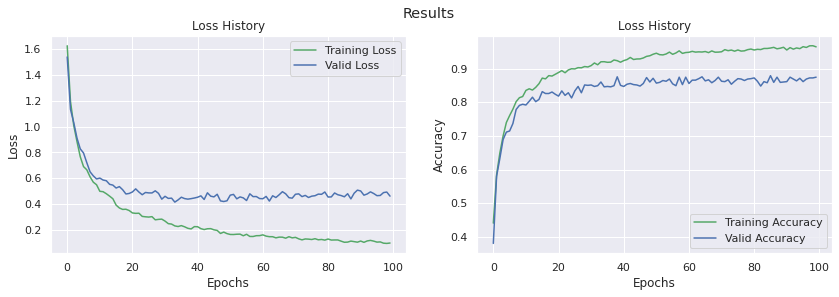

In [23]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history3 = trainer3.getHistory()
trainer3.showResults()

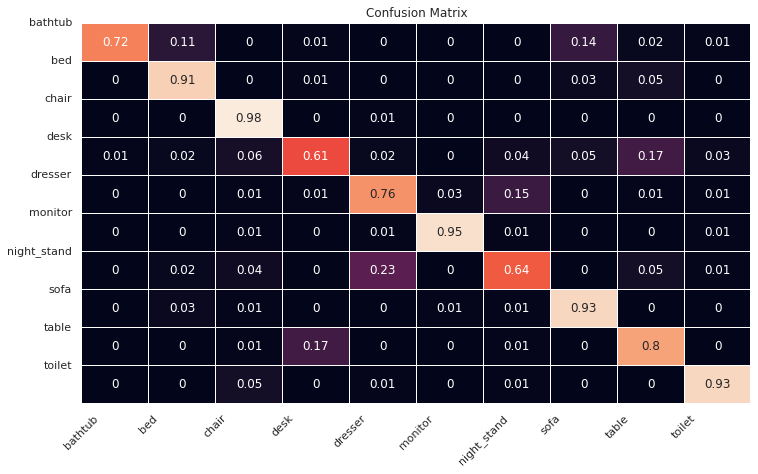

In [24]:
trainer3.generateConfusionMatrix()

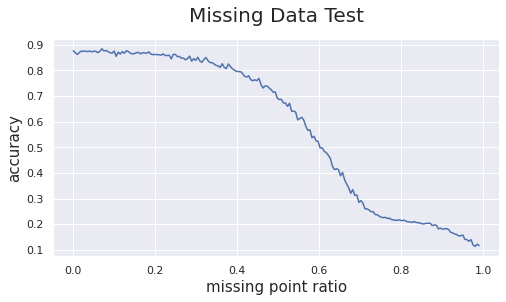

In [ ]:
trainer3.missing_data_test()

# VoxNet model comparison

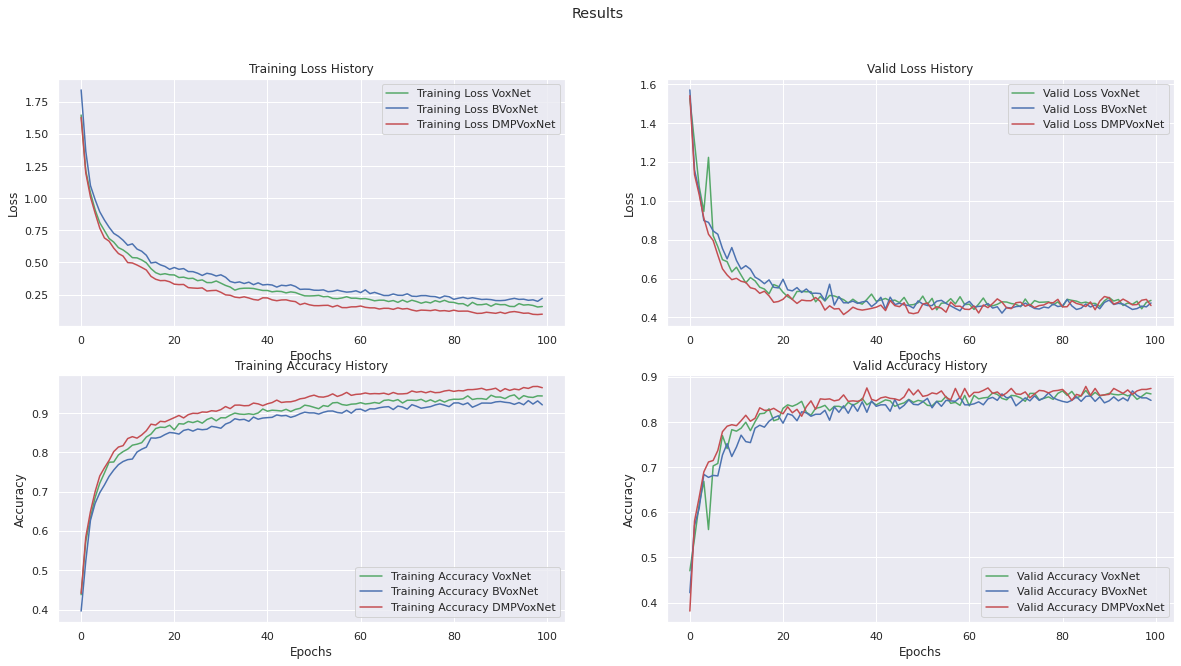

In [25]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

eps = range(0, len(history1["train_loss"].cpu()))
        
sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('Results')
        
ax[0,0].plot(eps, smooth(history1["train_loss"].cpu()), 'g', label='Training Loss VoxNet')
ax[0,0].plot(eps, smooth(history2["train_loss"].cpu()), 'b', label='Training Loss BVoxNet')
ax[0,0].plot(eps, smooth(history3["train_loss"].cpu()), 'r', label='Training Loss DMPVoxNet')
ax[0,0].set_title('Training Loss History')
ax[0,0].set(xlabel='Epochs', ylabel='Loss')
ax[0,0].legend()
        
ax[0,1].plot(eps, smooth(history1["valid_loss"].cpu()), 'g', label='Valid Loss VoxNet')
ax[0,1].plot(eps, smooth(history2["valid_loss"].cpu()), 'b', label='Valid Loss BVoxNet')
ax[0,1].plot(eps, smooth(history3["valid_loss"].cpu()), 'r', label='Valid Loss DMPVoxNet')
ax[0,1].set_title('Valid Loss History')
ax[0,1].set(xlabel='Epochs', ylabel='Loss')
ax[0,1].legend()

ax[1,0].plot(eps, smooth(history1["train_acc"].cpu()), 'g', label='Training Accuracy VoxNet')
ax[1,0].plot(eps, smooth(history2["train_acc"].cpu()), 'b', label='Training Accuracy BVoxNet')
ax[1,0].plot(eps, smooth(history3["train_acc"].cpu()), 'r', label='Training Accuracy DMPVoxNet')
ax[1,0].set_title('Training Accuracy History')
ax[1,0].set(xlabel='Epochs', ylabel='Accuracy')
ax[1,0].legend()

ax[1,1].plot(eps, smooth(history1["valid_acc"].cpu()), 'g', label='Valid Accuracy VoxNet')
ax[1,1].plot(eps, smooth(history2["valid_acc"].cpu()), 'b', label='Valid Accuracy BVoxNet')
ax[1,1].plot(eps, smooth(history3["valid_acc"].cpu()), 'r', label='Valid Accuracy DMPVoxNet')
ax[1,1].set_title('Valid Accuracy History')
ax[1,1].set(xlabel='Epochs', ylabel='Accuracy')
ax[1,1].legend()

# PointNet

In [ ]:
import os
import random
import math

!pip install path.py;
from path import Path

path = Path("ModelNet10")

folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)]
classes = {folder: i for i, folder in enumerate(folders)};

def read_off(file):
    if 'OFF' != file.readline().strip():
        raise('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        # barycentric coordinates on a triangle
        # https://mathworld.wolfram.com/BarycentricCoordinates.html
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))
        
    
    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]], verts[faces[i][1]], verts[faces[i][2]]))
            
        sampled_faces = (random.choices(faces, weights=areas, cum_weights=None, k=self.output_size))
        
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]], verts[sampled_faces[i][1]], verts[sampled_faces[i][2]]))
        
        return sampled_points


class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])
        
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud
    
class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.02, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud

class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        return torch.from_numpy(pointcloud)

In [ ]:
def default_transforms():
    return transforms.Compose([PointSampler(1024),
                                Normalize(),
                                ToTensor()
                              ])

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
class PointCloudData(Dataset):
    def __init__(self, root_dir, valid=False, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        verts, faces = read_off(file)
        if self.transforms:
            pointcloud = self.transforms((verts, faces))
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            pointcloud = self.__preproc__(f)
        return {'pointcloud': pointcloud, 'category': self.classes[category]}

In [ ]:
train_transforms = transforms.Compose([
                    PointSampler(1024),
                    Normalize(),
                    RandRotation_z(),
                    RandomNoise(),
                    ToTensor()
                    ])

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class Tnet(nn.Module):
   def __init__(self, k=3):
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)
      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)
       

   def forward(self, input):
      # input.shape == (bs,n,3)
      bs = input.size(0)
      xb = F.relu(self.bn1(self.conv1(input)))
      xb = F.relu(self.bn2(self.conv2(xb)))
      xb = F.relu(self.bn3(self.conv3(xb)))
      pool = nn.MaxPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool)
      xb = F.relu(self.bn4(self.fc1(flat)))
      xb = F.relu(self.bn5(self.fc2(xb)))
      
      #initialize as identity
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()
      matrix = self.fc3(xb).view(-1,self.k,self.k) + init
      return matrix


class Transform(nn.Module):
   def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
       

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
       
   def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

In [ ]:
def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

In [ ]:
from torch.optim import SGD, Adam
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm

class PointNet_Trainer():
  def __init__(self, hyperparameters):
      #Hypreparameters
      self.learning_rate = hyperparameters["learning_rate"]
      self.batch_size_train = hyperparameters["train_batch_size"]
      self.batch_size_test = hyperparameters["valid_batch_size"]
      self.data_size = hyperparameters["data_size"]
      self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      self.epochs = hyperparameters["epochs"]
      
      #Dataset
      self.initDataset()
      self.class_names = ["bathtub", "bed", "chair", "desk", "dresser", "monitor", "night_stand", "sofa", "table", "toilet"]
      self.num_classes = len(self.class_names)

      #Model
      self.initModel(hyperparameters)
  
  def initDataset(self):
      self.train_ds = PointCloudData(path, transform=train_transforms)
      self.test_ds = PointCloudData(path, valid=True, folder='test', transform=train_transforms)
      self.train_dataloader = DataLoader(dataset=self.train_ds, batch_size=self.batch_size_train, shuffle=True, drop_last=True)
      self.test_dataloader = DataLoader(dataset=self.test_ds, batch_size=self.batch_size_test)

  def initModel(self, hyperparameters):
      self.model = PointNet()
      print("model PointNet was chosen")
      self.device = "cuda" if torch.cuda.is_available() else "cpu"
      self.model.to(self.device)
      self.opt = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

  def train(self):
      self.pred_conf, self.y_conf = [], []                                                           
      train_loss_history, valid_loss_history = [], []
      train_acc_history, valid_acc_history = [], []
      train_accuracy = Accuracy(task='multiclass', num_classes=10)
      valid_accuracy = Accuracy(task='multiclass', num_classes=10)

      self.num_batch = len(self.train_ds) / self.batch_size_train
      print(self.num_batch)

      total_time = time.time()

      for epoch in range(self.epochs):
          t = time.time()

          train_loss = []                                                         #track training loss
          valid_loss = []
          self.model.train()
          iterator = tqdm(enumerate(self.train_dataloader, 0))
          for i, data in iterator:
              inputs, labels = data['pointcloud'].to(self.device).float(), data['category'].to(self.device)

              self.opt.zero_grad()
              outputs, m3x3, m64x64 = self.model(inputs.transpose(1,2))  # torch.Size([256, 10])
              loss = pointnetloss(outputs, labels, m3x3, m64x64)
              train_loss.append(loss.cpu().data)
              train_accuracy.update(torch.argmax(outputs, 1).cpu(), labels.cpu()) 

              loss.backward()
              self.opt.step()
              iterator.set_description(f"Train loss: {loss.cpu().data}")
                      
          with torch.no_grad():
            self.model.eval()
            for j, sample in tqdm(enumerate(self.test_dataloader, 0)):    
                inputs_test, labels_test = sample['pointcloud'].to(self.device).float(), sample['category'].to(self.device)
                
                outputs_test, m3x3, m64x64  = self.model(inputs_test.transpose(1,2))
                loss_test = pointnetloss(outputs_test, labels_test, m3x3, m64x64)
                valid_loss.append(loss_test.cpu().data)
                valid_accuracy.update(torch.argmax(outputs_test, 1).cpu(), labels_test.cpu())
                pred_choice_test = outputs_test.data.max(1)[1]

                correct_test = pred_choice_test.eq(labels_test.data).cpu().sum()
                self.pred_conf.append(torch.argmax(outputs_test, 1))
                self.y_conf.append(labels_test)

          #compute confusion matrix
          a = torch.cat(self.pred_conf).cpu()
          b = torch.cat(self.y_conf).cpu()
          confmat = ConfusionMatrix(task='multiclass', num_classes=10, normalize="true")
          self.conf_matrix = confmat(a, b)
          self.conf_matrix = torch.round(self.conf_matrix, decimals=2)

          # total accuracy over all batches
          total_train_accuracy = train_accuracy.compute()
          total_valid_accuracy = valid_accuracy.compute()
          train_accuracy.reset()
          valid_accuracy.reset()
            
          #track loss and acc for plotting
          train_loss_history.append(torch.mean(torch.tensor(train_loss)))
          valid_loss_history.append(torch.mean(torch.tensor(valid_loss)))
          train_acc_history.append(total_train_accuracy)
          valid_acc_history.append(total_valid_accuracy)
            
          elapsed_time_epoch = time.time() - t   
            
          tmp0 = "epoch:{:3d} /{:3d}".format(epoch+1, self.epochs)
          tmp1 = "time: {:.2f} seconds".format(elapsed_time_epoch)
          tmp2 = "train-loss: {:4.2f}, train-acc: {:.2%}".format(train_loss_history[epoch], train_acc_history[epoch].item())
          tmp3 = "valid-loss: {:4.2f}, valid-acc: {:.2%}\n".format(valid_loss_history[epoch], valid_acc_history[epoch].item())
          print(tmp0, tmp1, tmp2, tmp3, sep="\n")
          
          #save history
          self.history = {"train_loss": torch.tensor(train_loss_history), "train_acc": torch.tensor(train_acc_history), 
                          "valid_loss": torch.tensor(valid_loss_history), "valid_acc": torch.tensor(valid_acc_history)}
           
  def getHistory(self):
      return self.history

  def generateConfusionMatrix(self):
      fig=plt.figure(figsize = (12,7))
      sns.heatmap(self.conf_matrix, annot=True, fmt='g', linewidths=.4, cbar=False)
      tick_marks = np.arange(len(self.class_names))
      plt.xticks(tick_marks, self.class_names, rotation=45)
      plt.yticks(tick_marks, self.class_names, rotation=0)
      plt.title("Confusion Matrix")     

  def getPerClassAccuracy(self):
      per_class_accuracy = 100 * torch.diag(self.conf_matrix) / torch.sum(self.conf_matrix, 1)
      tmp = {}
      for i, x in enumerate(self.class_names):
        tmp[x] = per_class_accuracy[i].item()
      print(tmp)
    
  def showResults(self):
      eps = range(0, len(self.history["train_loss"].cpu()))
        
      sns.set_theme()
      fig, ax = plt.subplots(1, 2, figsize=(14, 4))
      fig.suptitle('Results')
        
      ax[0].plot(eps, smooth(self.history["train_loss"].cpu()), 'g', label='Training Loss')
      ax[0].plot(eps, smooth(self.history["valid_loss"].cpu()), 'b', label='Valid Loss')
      ax[0].set_title('Loss History')
      ax[0].set(xlabel='Epochs', ylabel='Loss')
      ax[0].legend()
        
      ax[1].plot(eps, smooth(self.history["train_acc"].cpu()), 'g', label='Training Accuracy')
      ax[1].plot(eps, smooth(self.history["valid_acc"].cpu()), 'b', label='Valid Accuracy')
      ax[1].set_title('Loss History')
      ax[1].set(xlabel='Epochs', ylabel='Accuracy')
      ax[1].legend()
        
  def test_on_missing_data(self, missing_rate=0.5):
      test_accuracy = Accuracy(task='multiclass', num_classes=10)
        
      self.model.eval()
      for x, y in self.test_dataloader:
          x, y = x.to(self.device), y.to(self.device)
            
          idc = np.random.choice(32**3, size=(int(32**3*missing_rate)), replace=False)
          idc_x = idc%32
          idc_y = np.floor_divide(idc, 32)%32
          idc_z = np.floor_divide(idc, 32*32)%32
          x[:, :, idc_x, idc_y, idc_z] = 0
            
          pred = self.model(x)
          test_accuracy.update(torch.argmax(pred, 1).cpu(), y.cpu())
            
      return test_accuracy.compute()
    
  def missing_data_test(self):
      acc = []
      delta = 200
      eps = np.linspace(0,0.99,delta)
      for x in eps:
          tmp = self.test_on_missing_data(x)
          acc.append(tmp)
            
            
      sns.set_theme()
      plt.figure(figsize=(8, 4))
      plt.plot(eps, smooth(acc))
      plt.title("Missing Data Test", size=20, y=1.05)
      plt.xlabel("missing point ratio", size=15)
      plt.ylabel("accuracy", size=15)
      plt.show()

In [ ]:
training_hyperparameters = {
    "learning_rate": 0.001,
    "data_size": 32,
    "epochs": 20,
    "train_batch_size": 32,
    "valid_batch_size": 64,
}    

trainer4 = PointNet_Trainer(training_hyperparameters)
trainer4.train()

model PointNet was chosen
124.71875


Train loss: 0.7721420526504517: : 124it [26:39, 12.90s/it]
15it [04:14, 16.95s/it]


epoch:  1 / 20
time: 1853.85 seconds
train-loss: 1.26, train-acc: 58.52%
valid-loss: 1.74, valid-acc: 47.36%



Train loss: 1.2494457960128784: : 124it [26:28, 12.81s/it]
15it [04:16, 17.12s/it]


epoch:  2 / 20
time: 1844.92 seconds
train-loss: 0.79, train-acc: 72.88%
valid-loss: 0.76, valid-acc: 72.69%



Train loss: 0.7019855976104736: : 124it [26:56, 13.04s/it]
15it [04:18, 17.24s/it]


epoch:  3 / 20
time: 1875.00 seconds
train-loss: 0.67, train-acc: 77.32%
valid-loss: 0.80, valid-acc: 70.48%



Train loss: 0.6342124342918396: : 124it [26:27, 12.81s/it]
15it [04:18, 17.26s/it]


epoch:  4 / 20
time: 1846.81 seconds
train-loss: 0.58, train-acc: 80.52%
valid-loss: 0.55, valid-acc: 81.94%



Train loss: 0.7971304059028625: : 124it [26:51, 13.00s/it]
15it [04:19, 17.28s/it]


epoch:  5 / 20
time: 1870.70 seconds
train-loss: 0.51, train-acc: 83.19%
valid-loss: 0.59, valid-acc: 77.31%



Train loss: 0.4183681309223175: : 124it [25:03, 12.13s/it]
15it [03:57, 15.85s/it]


epoch:  6 / 20
time: 1741.73 seconds
train-loss: 0.50, train-acc: 83.22%
valid-loss: 0.53, valid-acc: 81.17%



Train loss: 0.8445573449134827: : 124it [24:50, 12.02s/it]
15it [03:59, 15.96s/it]


epoch:  7 / 20
time: 1729.97 seconds
train-loss: 0.48, train-acc: 83.74%
valid-loss: 0.54, valid-acc: 82.71%



Train loss: 0.24197641015052795: : 124it [24:51, 12.03s/it]
15it [03:55, 15.69s/it]


epoch:  8 / 20
time: 1726.66 seconds
train-loss: 0.45, train-acc: 84.63%
valid-loss: 0.50, valid-acc: 83.26%



Train loss: 0.31993040442466736: : 124it [24:52, 12.03s/it]
15it [03:58, 15.88s/it]


epoch:  9 / 20
time: 1730.58 seconds
train-loss: 0.45, train-acc: 85.03%
valid-loss: 0.62, valid-acc: 81.06%



Train loss: 0.2875419855117798: : 124it [24:57, 12.08s/it]
15it [03:55, 15.69s/it]


epoch: 10 / 20
time: 1733.08 seconds
train-loss: 0.42, train-acc: 86.34%
valid-loss: 0.51, valid-acc: 81.39%



Train loss: 0.24406695365905762: : 124it [24:48, 12.01s/it]
15it [03:58, 15.89s/it]


epoch: 11 / 20
time: 1727.08 seconds
train-loss: 0.40, train-acc: 86.79%
valid-loss: 0.79, valid-acc: 72.36%



Train loss: 0.28334829211235046: : 124it [25:01, 12.11s/it]
15it [03:58, 15.90s/it]


epoch: 12 / 20
time: 1739.55 seconds
train-loss: 0.37, train-acc: 87.73%
valid-loss: 0.59, valid-acc: 78.85%



Train loss: 0.3324269652366638: : 124it [24:55, 12.06s/it]
15it [04:01, 16.07s/it]


epoch: 13 / 20
time: 1736.95 seconds
train-loss: 0.37, train-acc: 87.53%
valid-loss: 0.54, valid-acc: 82.05%



Train loss: 0.2053554803133011: : 86it [17:50, 14.31s/it]

In [69]:
training_hyperparameters = {
    "learning_rate": 0.1,
    "sgd_momentum": 0,
    "data_size": 32,
    "epochs": 100,
    "lr_scheduler_step": 16,
    "lr_scheduler_gamma": 0.7,
    "train_batch_size": 32,
    "valid_batch_size": 32,
    "model" : 'VoxNet'
}    

trainer5 = VoxNet_Trainer(training_hyperparameters)
trainer5.train()

model VoxNet was chosen
124.71875


Train loss: 1.033944845199585: : 124it [01:17,  1.60it/s]
29it [00:10,  2.77it/s]


epoch:  1 /100
time: 88.21 seconds
train-loss: 1.68, train-acc: 41.41%
valid-loss: 1.79, valid-acc: 33.26%



Train loss: 1.3101292848587036: : 124it [01:18,  1.59it/s]
29it [00:11,  2.48it/s]


epoch:  2 /100
time: 89.82 seconds
train-loss: 1.23, train-acc: 56.91%
valid-loss: 1.17, valid-acc: 58.26%



Train loss: 0.853866457939148: : 124it [01:16,  1.62it/s]
29it [00:10,  2.82it/s]


epoch:  3 /100
time: 86.95 seconds
train-loss: 1.03, train-acc: 64.52%
valid-loss: 0.98, valid-acc: 65.09%



Train loss: 0.4096955955028534: : 124it [01:17,  1.60it/s]
29it [00:10,  2.79it/s]


epoch:  4 /100
time: 88.10 seconds
train-loss: 0.88, train-acc: 69.96%
valid-loss: 0.92, valid-acc: 66.08%



Train loss: 0.6165271401405334: : 124it [01:17,  1.61it/s]
29it [00:10,  2.78it/s]


epoch:  5 /100
time: 87.57 seconds
train-loss: 0.78, train-acc: 73.16%
valid-loss: 0.79, valid-acc: 70.48%



Train loss: 0.5137845277786255: : 124it [01:18,  1.58it/s]
29it [00:10,  2.74it/s]


epoch:  6 /100
time: 89.19 seconds
train-loss: 0.73, train-acc: 75.45%
valid-loss: 0.82, valid-acc: 69.71%



Train loss: 0.506099283695221: : 7it [00:05,  1.38it/s]


KeyboardInterrupt: ignored

best model was trained at: 5epoch
with a validation loss of: tensor(0.7919) and a validation accuracy of: tensor(0.7048)


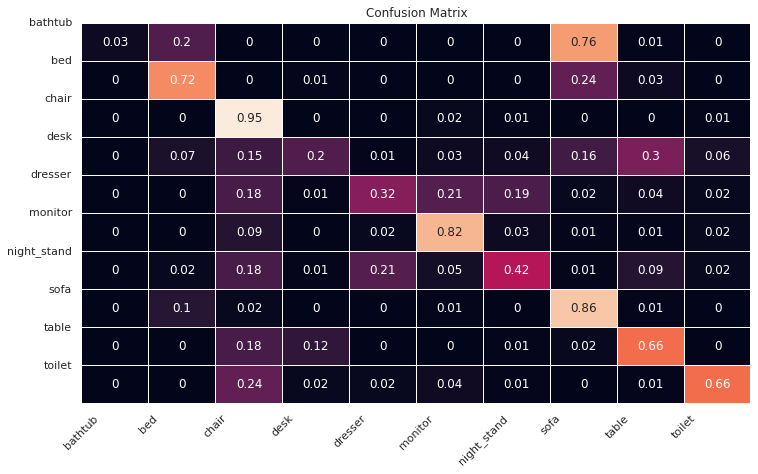

In [70]:
trainer5.generateConfusionMatrix()

In [62]:
trainer5.missing_data_test()

KeyboardInterrupt: ignored